# Pre-employment coursework
## Exercise 5 - Generative Adversarial Network

- **Model:** A Vanilla GAN with WGAN-GP loss
- **Aim:** Model should be trained to generate new instances of the training data.
- **Sources:** Gulrajani, (2017), *Improved Training of Wasserstein GANs*, https://arxiv.org/pdf/1704.00028.pdf

In [1]:
# Imports
import os
import sys
import time
import json
import itertools
from itertools import product
from collections import OrderedDict
from collections import namedtuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.utils.tensorboard import SummaryWriter
torch.set_printoptions(linewidth=120)
torch.set_grad_enabled(True) # set False to disable gradient calculations at runtime

import torchvision
from torchvision.utils import make_grid
from torchvision.transforms import transforms

from IPython.display import display, clear_output






from utils import *

In [2]:
print(torch.__version__)
print(torchvision.__version__)

1.3.0
0.4.1


## Load the MNIST dataset

In [3]:
# Define transform
"""
transform = transforms.Compose(
    [transforms.FiveCrop(24),
     transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
     transforms.Lambda(lambda crops: torch.stack([transforms.Normalize((0.5,), (0.5,))(crop) for crop in crops]))])
"""
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

# Load data
train_set = torchvision.datasets.MNIST(root='../data', train=True,
                                       download=True, transform=transform)

test_set = torchvision.datasets.MNIST(root='../data', train=False,
                                      download=True, transform=transform)

## Define model

In [4]:
class DiscriminatorNet(nn.Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 784
        n_out = 1
        
        self.layers = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, inputs):
        output = self.layers(inputs)
        return output

In [5]:
class GeneratorNet(nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self, n_features):
        super(GeneratorNet, self).__init__()
        n_out = 784
        
        self.layers = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    def forward(self, inputs):
        generated_img = self.layers(inputs)
        return generated_img

In [6]:
class Model(nn.Module):
    """
    A Generative Adversarial Network model.
    """
    def __init__(self, n_features):
        super(Model, self).__init__()
        self.n_features = n_features
        self.discriminator = DiscriminatorNet()
        self.generator = GeneratorNet(n_features)
        self.d_optimizer = None
        self.g_optimizer = None
    
    def set_optimizers(self, d_optimizer, g_optimizer):
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        
    def sample(self, batch_size):
        """
        Generates Gaussian sampled random values for image generation.
        """
        return torch.randn((batch_size, self.n_features))
    
    def ones_target(self, batch_size):
        """
        Tensor containing ones, representing real images.
        """
        return torch.ones((batch_size, 1))

    def zeros_target(self, batch_size):
        """
        Tensor containing zeros, representing fake images.
        """
        return torch.zeros((batch_size, 1))

    def train_func(self, optimizer, fake_data, real_data=None, mode='generator'):
        assert mode in ['generator', 'discriminator'], "Mode must be either 'generator' or 'discriminator'."

        # Define loss and batch size
        loss = nn.BCELoss(reduction='none')
        b_size = fake_data.size(0)

        # Reset gradients
        optimizer.zero_grad()

        # If training discriminator, train on real data first
        if mode == 'discriminator':
            pred_real = self.discriminator(real_data)
            error_real = loss(pred_real, self.ones_target(b_size)).sum()
            error_real.backward()

        # Train on fake data
        pred_fake = self.discriminator(fake_data)

        # Calculate loss and backpropagate optimizer
        if mode == 'generator':
            error_fake = loss(pred_fake, self.ones_target(b_size)).sum()
            error_fake.backward()
            optimizer.step()
            return error_fake

        elif mode == 'discriminator':
            error_fake = loss(pred_fake, self.zeros_target(b_size)).sum()
            error_fake.backward()
            optimizer.step()
            error_mean = (error_real + error_fake) / 2
            return error_mean
    
    def evaluate(self, inputs, latents, display=True):
        """
        Displays real images and fake images and evaluates error for each set.
        """
        with torch.no_grad():
            fake_data = self.generator(latents)
            
        if display:
            print("Real images:")
            imgviz(inputs)
            print("Fake images:")
            imgviz(fake_data)
        
        real_data = images_to_vectors(inputs)
        b_size = real_data.size(0)
        
        with torch.no_grad():
            loss = nn.BCELoss(reduction='none')
            pred_real = self.discriminator(real_data)
            pred_fake = self.discriminator(fake_data)
            error_real = loss(pred_real, self.ones_target(b_size)).sum()
            error_fake = loss(pred_fake, self.zeros_target(b_size)).sum()
            error_d = (error_real + error_fake) / 2
            error_g = loss(pred_fake, self.ones_target(b_size)).sum()
        
        return error_d, error_g
    
    def forward(self, inputs):
        batch_size = inputs.size(0)
        real_data = images_to_vectors(inputs)
        
        # Generate fake data without gradients
        with torch.no_grad():
            fake_data = self.generator(self.sample(batch_size))
        
        # Train discriminator
        error_d = self.train_func(self.d_optimizer, fake_data, real_data, mode='discriminator')
        
        # Generate new set of fake data
        fake_data = self.generator(self.sample(batch_size))
        
        # Train generator
        error_g = self.train_func(self.g_optimizer, fake_data, mode='generator')
        
        return error_d, error_g

In [7]:
parameters = OrderedDict(
    init_lr = [0.0002],
    batch_size = [128]
)

run  epoch  train loss (disc)  train loss (gen)  validation loss (disc)  \
0      1      1           0.485155          2.704309                1.622852   
1      1      2           0.541408          1.902835                1.691936   
2      1      3           0.572664          1.149247                1.814465   
3      1      4           0.399328          2.396757                1.145347   
4      1      5           0.336056          2.366348                0.949176   
5      1      6           0.307399          2.616953                0.970227   
6      1      7           0.273991          2.603411                0.919796   
7      1      8           0.300053          2.569857                1.049983   
8      1      9           0.282170          2.460121                0.913218   
9      1     10           0.303159          2.358052                0.787948   
10     1     11           0.311431          2.235277                0.877241   
11     1     12           0.324417          2.258986                1.052097   
12     1     13           0.331124          2.122903                1.070138   
13     1     14           0.358359          2.051372                1.029528   
14     1     15           0.360601          2.093316                1.054054   
15     1     16           0.375922          1.973167                1.205929   
16     1     17           0.399982          1.837218                1.278673   
17     1     18           0.391735          1.874114                1.131865   
18     1     19           0.388201          1.911017                1.195515   
19     1     20           0.400884          1.831882                1.146281   
20     1     21           0.401036          1.848669                1.360742   
21     1     22           0.428242          1.706260                1.204457   
22     1     23           0.440222          1.683680                1.278133   
23     1     24           0.428402          1.724367                1.360000   
24     1     25           0.439892          1.664412                1.280463   
25     1     26           0.453913          1.613509                1.490068   
26     1     27           0.451475          1.577565                1.362951   
27     1     28           0.452207          1.590803                1.287387   
28     1     29           0.450057          1.607831                1.434299   
29     1     30           0.478821          1.497965                1.428129   
..   ...    ...                ...               ...                     ...   
270    1    271           0.648646          0.851405                2.167184   
271    1    272           0.650116          0.855473                2.117623   
272    1    273           0.650253          0.852281                2.099627   
273    1    274           0.648053          0.858054                2.122757   
274    1    275           0.649572          0.850946                2.135824   
275    1    276           0.651268          0.836708                2.085076   
276    1    277           0.649527          0.853151                2.058195   
277    1    278           0.651399          0.859082                2.014456   
278    1    279           0.645176          0.871928                2.064421   
279    1    280           0.646800          0.855294                2.050976   
280    1    281           0.650148          0.851718                2.123434   
281    1    282           0.650892          0.856065                2.129639   
282    1    283           0.647177          0.857593                2.170693   
283    1    284           0.647682          0.859281                2.099360   
284    1    285           0.651847          0.838233                2.160414   
285    1    286           0.649699          0.855689                2.129417   
286    1    287           0.651006          0.844428                2.149420   
287    1    288           0.647805          0.858684                2.089124   
288  

Real images:


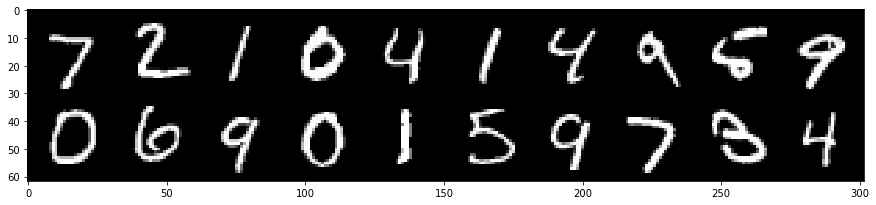

Fake images:


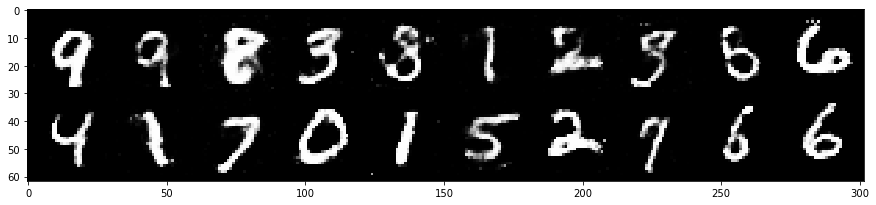

Model has finished training.

Training completed.


/Users/janxu/anaconda3/envs/tf/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Model. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/janxu/anaconda3/envs/tf/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type DiscriminatorNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/janxu/anaconda3/envs/tf/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/janxu/anaconda3/envs/tf/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon 

In [8]:
m = RunManager()
num_epochs = 300
num_samples = 20
latent_dim = 64

for hparams in RunBuilder.get_runs(parameters):

    # Instantiate a GAN model
    model = Model(latent_dim)

    # Construct a DataLoader object with training data
    train_loader = DataLoader(train_set, batch_size=hparams.batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=num_samples)
    test_images, _ = next(iter(test_loader))
    
    # Define random samples from standard Normal distribution for image generation
    test_latents = model.sample(num_samples)
    
    # Define optimizers
    d_optimizer = optim.Adam(model.discriminator.parameters(), lr=hparams.init_lr)
    g_optimizer = optim.Adam(model.generator.parameters(), lr=hparams.init_lr)
    model.set_optimizers(d_optimizer, g_optimizer)
    
    # Setup run instance
    m.begin_run(hparams, model, train_loader, test_images, test_latents)
    model.evaluate(test_images, test_latents, display=True)
    print('Now training model with hyperparameters: init_lr={0}, batch_size={1}'
         .format(hparams.init_lr, hparams.batch_size))
    
    # Start training loop
    for epoch in range(num_epochs):
        m.begin_epoch()
        
        # Train the model
        for i, batch in enumerate(train_loader):
            images, _ = batch

            # Calculating the loss
            error_d, error_g = model(images)
            
            if i % 10 == 0:
                with torch.no_grad():
                    val_error_d, val_error_g = model.evaluate(test_images, test_latents, display=False)
                    m.track_loss(val_error_d, val_error_g, mode='val')
                print('Epoch {0}, iteration {1}: train losses (d, g) ({2}, {3}), val losses (d, g) ({4}, {5})'
                      .format(epoch+1, i*hparams.batch_size,
                              round(error_d.item() / hparams.batch_size, 6),
                              round(error_g.item() / hparams.batch_size, 6),
                              round(val_error_d.item() / num_samples, 6),
                              round(val_error_g.item() / num_samples, 6)))

            m.track_loss(error_d, error_g, mode='train')
            
        m.end_epoch()
    
    torch.save(model, './models/' + str(hparams) + '.pth')
    m.end_run()
    print("Model has finished training.\n")
    
m.save('results2')
print("Training completed.")

In [61]:
num_test_samples = 16
test_noise = noise(num_test_samples)

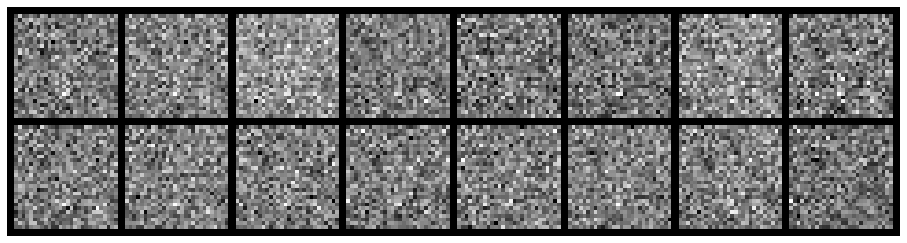

Epoch: [0/20], Batch Num: [0/600]
Discriminator Loss: 1.3655, Generator Loss: 0.6814
D(x): 0.5166, D(G(z)): 0.5058


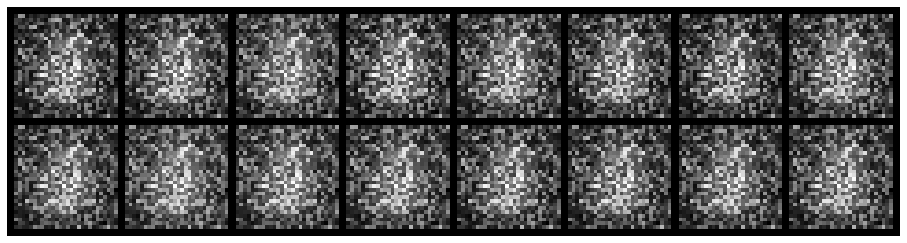

Epoch: [0/20], Batch Num: [100/600]
Discriminator Loss: 1.4295, Generator Loss: 1.6136
D(x): 0.6451, D(G(z)): 0.4572


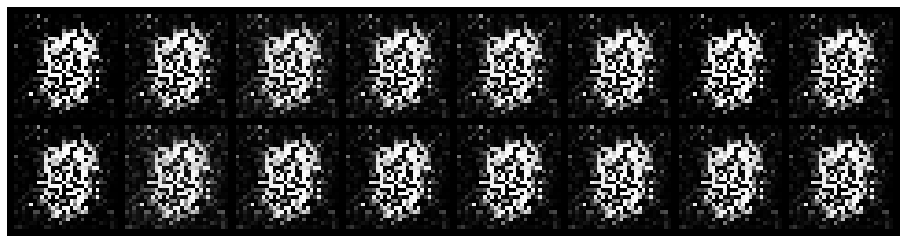

Epoch: [0/20], Batch Num: [200/600]
Discriminator Loss: 0.3262, Generator Loss: 3.0819
D(x): 0.8927, D(G(z)): 0.1624


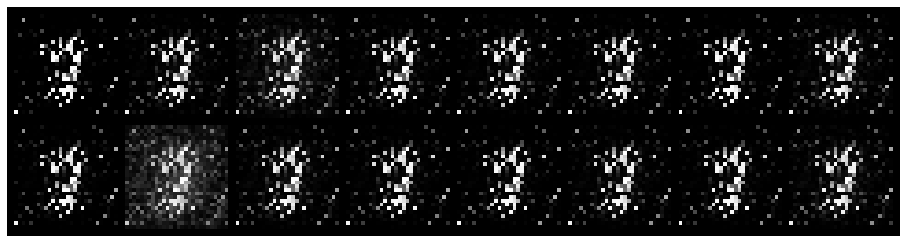

Epoch: [0/20], Batch Num: [300/600]
Discriminator Loss: 0.2875, Generator Loss: 4.1173
D(x): 0.8495, D(G(z)): 0.0650


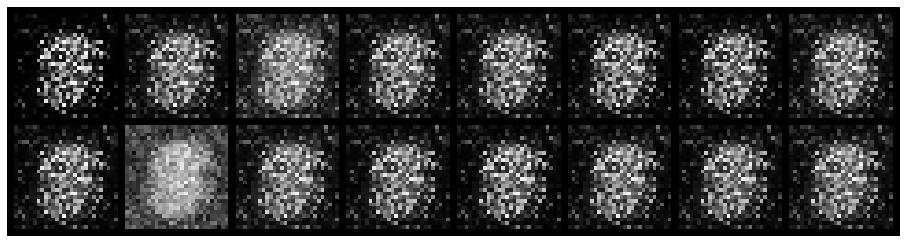

Epoch: [0/20], Batch Num: [400/600]
Discriminator Loss: 1.1559, Generator Loss: 1.8647
D(x): 0.6454, D(G(z)): 0.3637


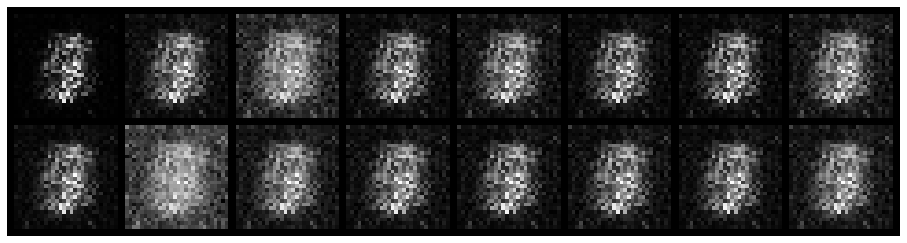

Epoch: [0/20], Batch Num: [500/600]
Discriminator Loss: 0.7077, Generator Loss: 1.8619
D(x): 0.7428, D(G(z)): 0.2950


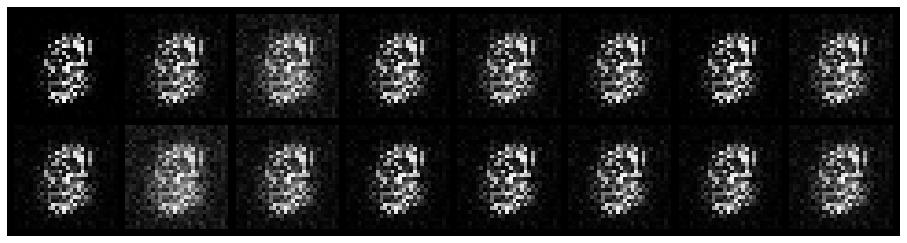

Epoch: [1/20], Batch Num: [0/600]
Discriminator Loss: 0.7277, Generator Loss: 1.7464
D(x): 0.6974, D(G(z)): 0.2506


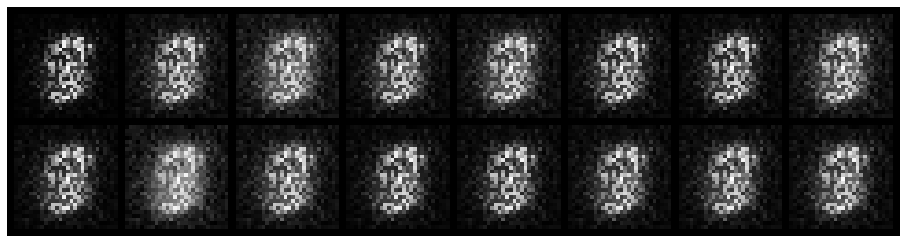

Epoch: [1/20], Batch Num: [100/600]
Discriminator Loss: 1.7008, Generator Loss: 0.8471
D(x): 0.6576, D(G(z)): 0.6123


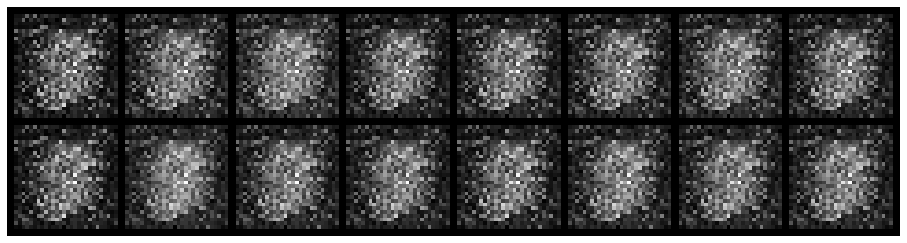

Epoch: [1/20], Batch Num: [200/600]
Discriminator Loss: 0.7378, Generator Loss: 1.6535
D(x): 0.6967, D(G(z)): 0.2904


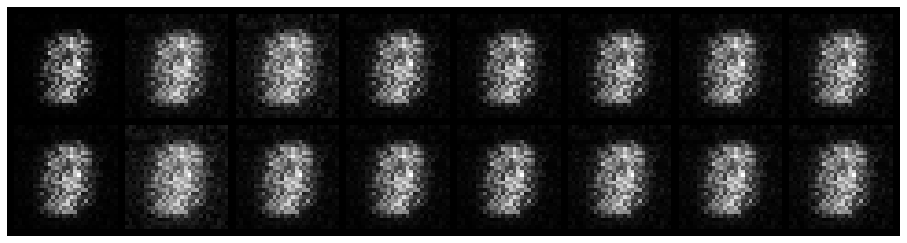

Epoch: [1/20], Batch Num: [300/600]
Discriminator Loss: 1.1423, Generator Loss: 1.1863
D(x): 0.5827, D(G(z)): 0.4096


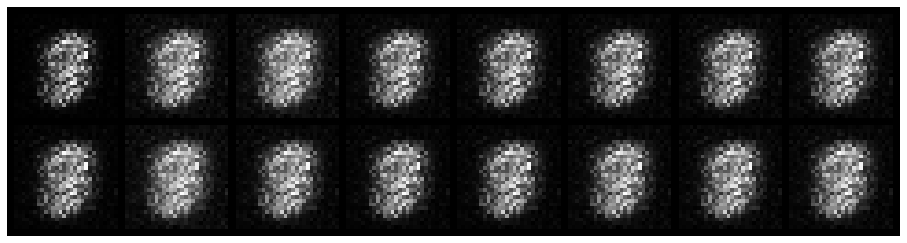

Epoch: [1/20], Batch Num: [400/600]
Discriminator Loss: 1.0487, Generator Loss: 1.0094
D(x): 0.6330, D(G(z)): 0.4103


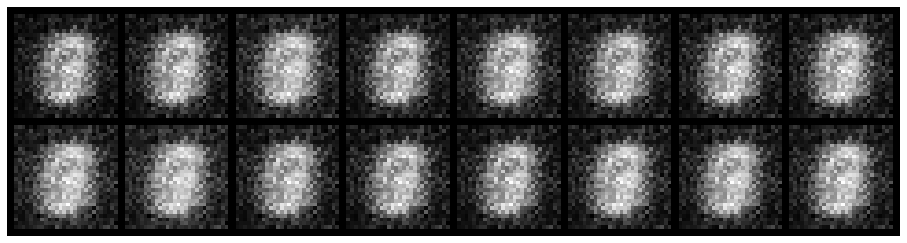

Epoch: [1/20], Batch Num: [500/600]
Discriminator Loss: 1.3688, Generator Loss: 0.6898
D(x): 0.6207, D(G(z)): 0.5382


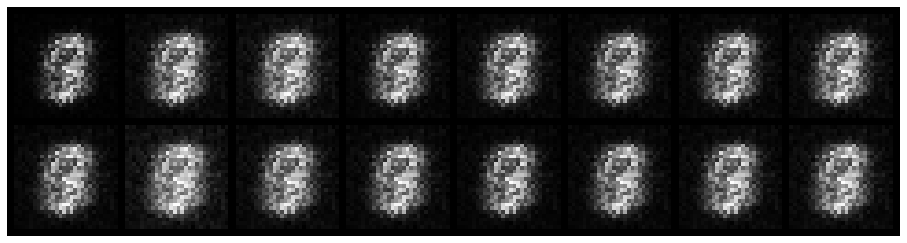

Epoch: [2/20], Batch Num: [0/600]
Discriminator Loss: 1.7623, Generator Loss: 0.6415
D(x): 0.4859, D(G(z)): 0.5827


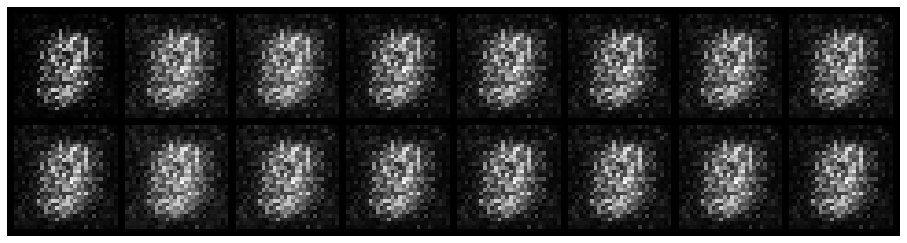

Epoch: [2/20], Batch Num: [100/600]
Discriminator Loss: 0.7000, Generator Loss: 2.4060
D(x): 0.6631, D(G(z)): 0.2123


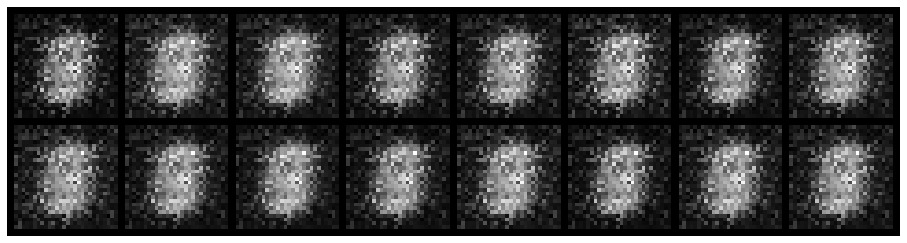

Epoch: [2/20], Batch Num: [200/600]
Discriminator Loss: 1.3108, Generator Loss: 1.1237
D(x): 0.6854, D(G(z)): 0.5130


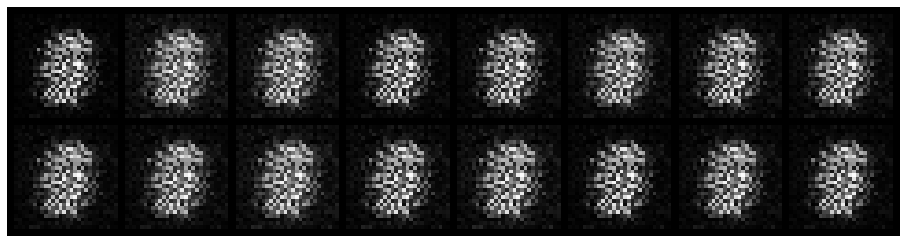

Epoch: [2/20], Batch Num: [300/600]
Discriminator Loss: 0.3973, Generator Loss: 3.2091
D(x): 0.8483, D(G(z)): 0.1783


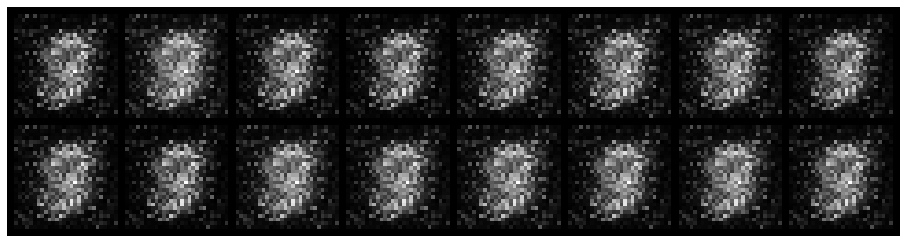

Epoch: [2/20], Batch Num: [400/600]
Discriminator Loss: 1.4073, Generator Loss: 1.3109
D(x): 0.4926, D(G(z)): 0.4259


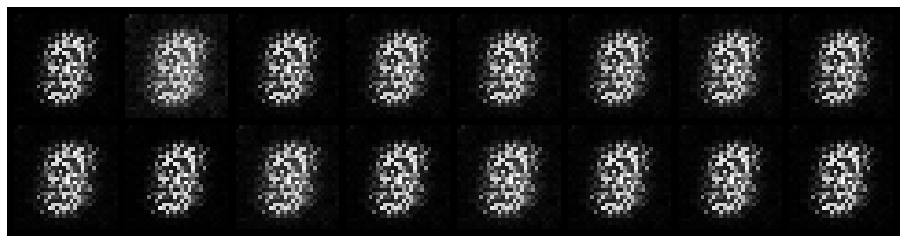

Epoch: [2/20], Batch Num: [500/600]
Discriminator Loss: 0.8872, Generator Loss: 2.6137
D(x): 0.6486, D(G(z)): 0.2181


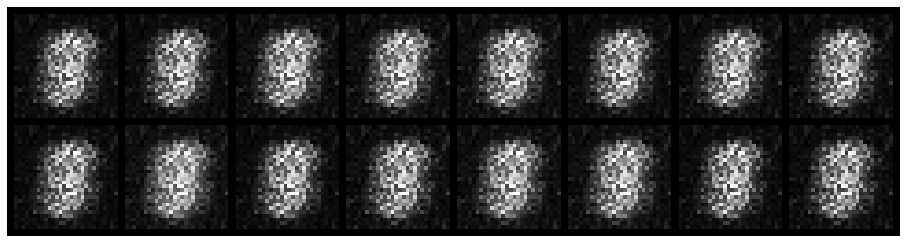

Epoch: [3/20], Batch Num: [0/600]
Discriminator Loss: 0.9090, Generator Loss: 1.1401
D(x): 0.7024, D(G(z)): 0.3595


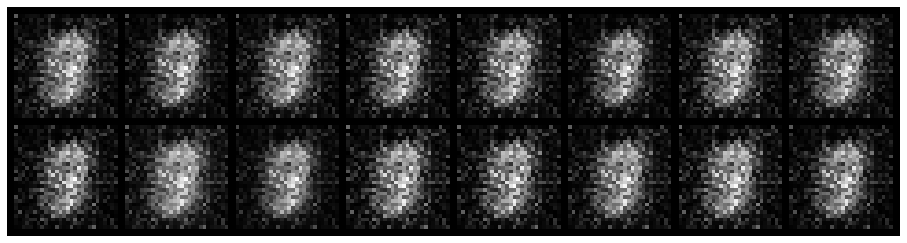

Epoch: [3/20], Batch Num: [100/600]
Discriminator Loss: 1.2251, Generator Loss: 1.0409
D(x): 0.7853, D(G(z)): 0.5341


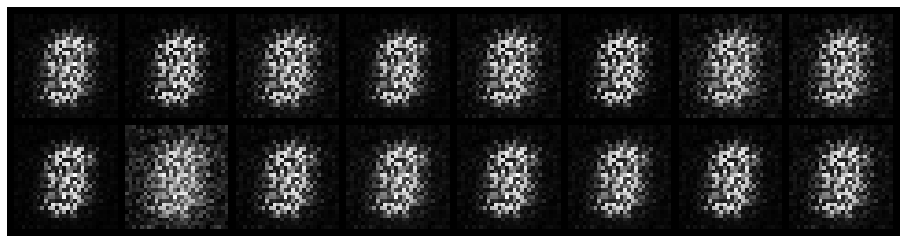

Epoch: [3/20], Batch Num: [200/600]
Discriminator Loss: 0.2858, Generator Loss: 4.0996
D(x): 0.9552, D(G(z)): 0.1650


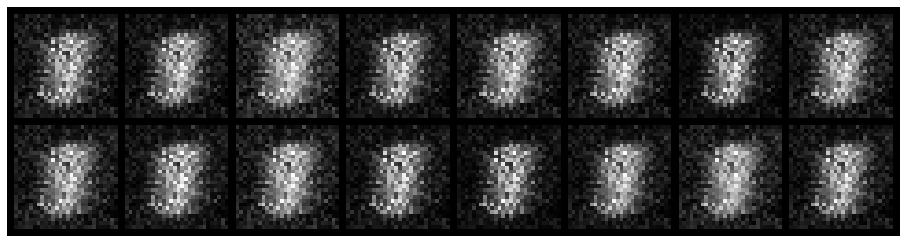

Epoch: [3/20], Batch Num: [300/600]
Discriminator Loss: 0.6690, Generator Loss: 2.8494
D(x): 0.7444, D(G(z)): 0.2010


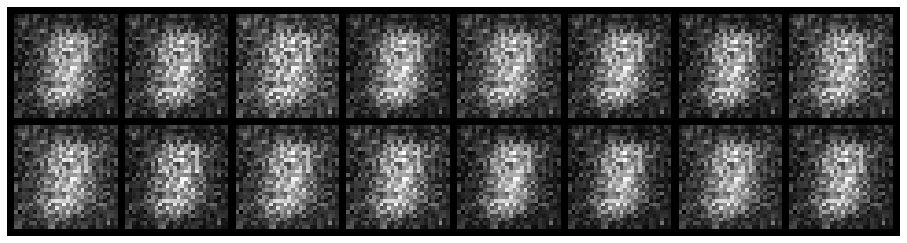

Epoch: [3/20], Batch Num: [400/600]
Discriminator Loss: 0.6173, Generator Loss: 1.2685
D(x): 0.8728, D(G(z)): 0.3510


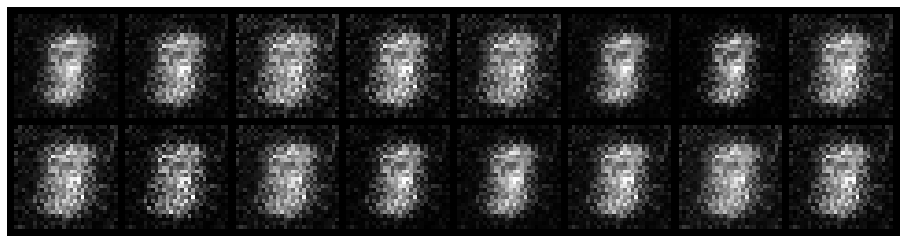

Epoch: [3/20], Batch Num: [500/600]
Discriminator Loss: 1.3000, Generator Loss: 1.2920
D(x): 0.6773, D(G(z)): 0.3956


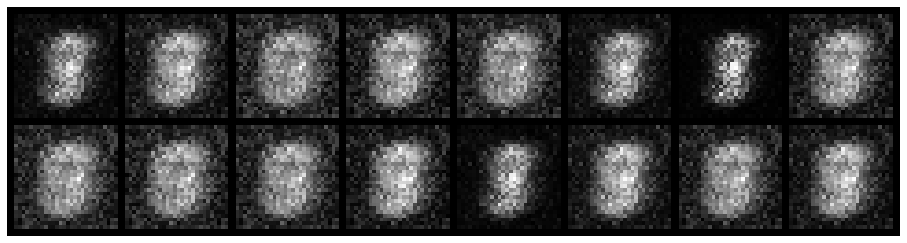

Epoch: [4/20], Batch Num: [0/600]
Discriminator Loss: 0.3312, Generator Loss: 2.1761
D(x): 0.8925, D(G(z)): 0.1598


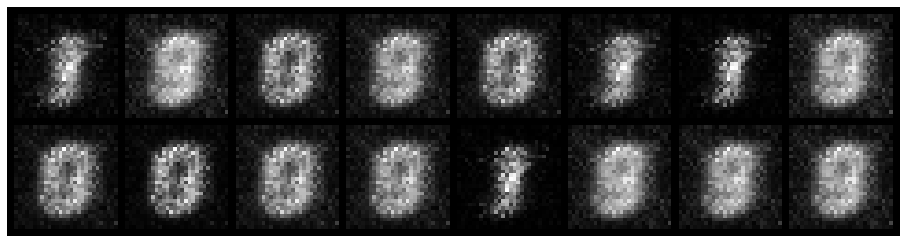

Epoch: [4/20], Batch Num: [100/600]
Discriminator Loss: 0.6165, Generator Loss: 1.9804
D(x): 0.7568, D(G(z)): 0.1621


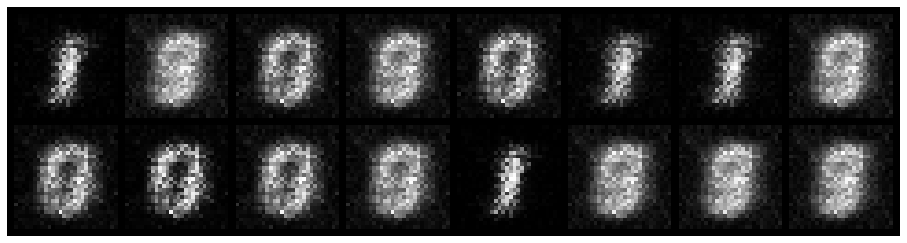

Epoch: [4/20], Batch Num: [200/600]
Discriminator Loss: 0.5744, Generator Loss: 1.7254
D(x): 0.8349, D(G(z)): 0.2300


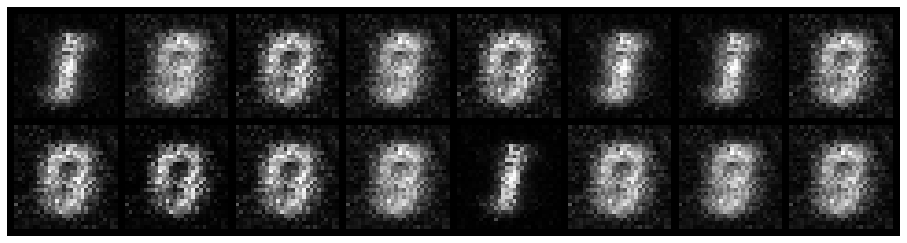

Epoch: [4/20], Batch Num: [300/600]
Discriminator Loss: 0.5324, Generator Loss: 2.3443
D(x): 0.9141, D(G(z)): 0.2699


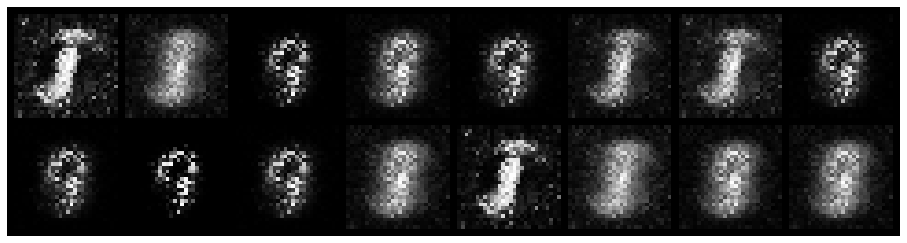

Epoch: [4/20], Batch Num: [400/600]
Discriminator Loss: 0.4768, Generator Loss: 2.5926
D(x): 0.8932, D(G(z)): 0.1939


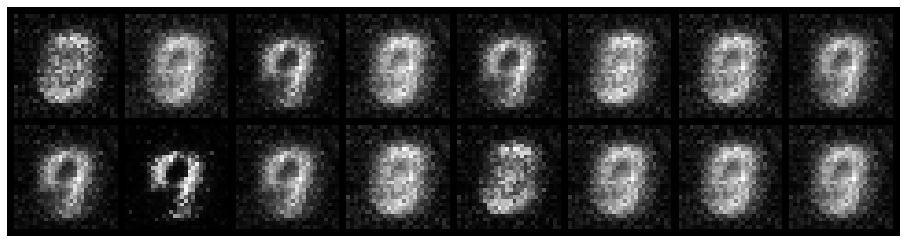

Epoch: [4/20], Batch Num: [500/600]
Discriminator Loss: 0.4214, Generator Loss: 2.9391
D(x): 0.8424, D(G(z)): 0.1389


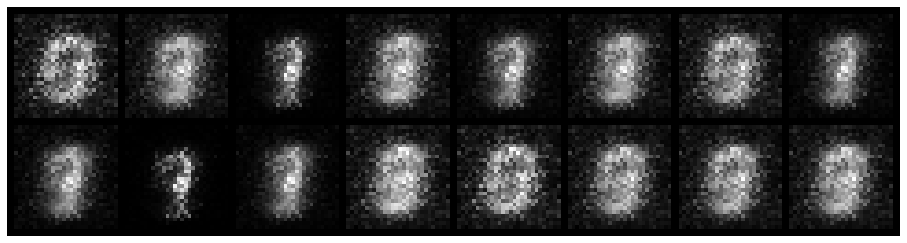

Epoch: [5/20], Batch Num: [0/600]
Discriminator Loss: 0.3988, Generator Loss: 2.1384
D(x): 0.8841, D(G(z)): 0.1694


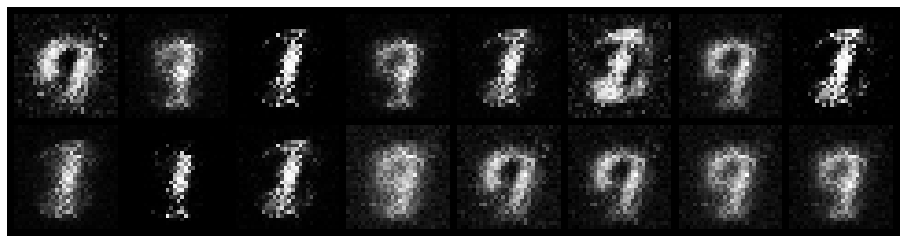

Epoch: [5/20], Batch Num: [100/600]
Discriminator Loss: 0.5156, Generator Loss: 3.6428
D(x): 0.8166, D(G(z)): 0.1069


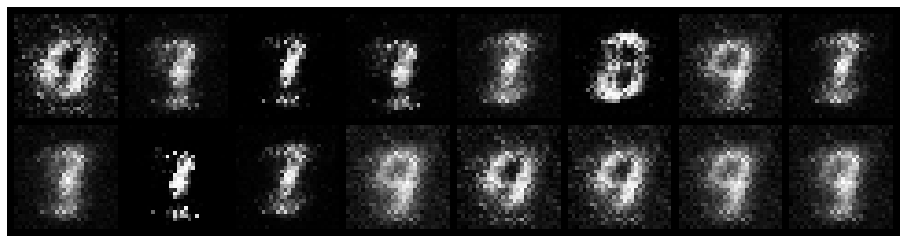

Epoch: [5/20], Batch Num: [200/600]
Discriminator Loss: 0.2609, Generator Loss: 2.8199
D(x): 0.9548, D(G(z)): 0.1482


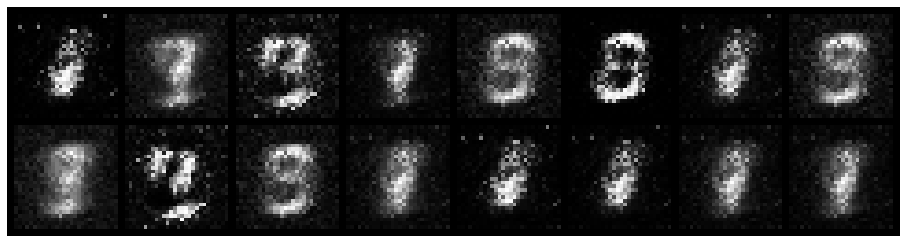

Epoch: [5/20], Batch Num: [300/600]
Discriminator Loss: 0.7535, Generator Loss: 2.0419
D(x): 0.7947, D(G(z)): 0.2174


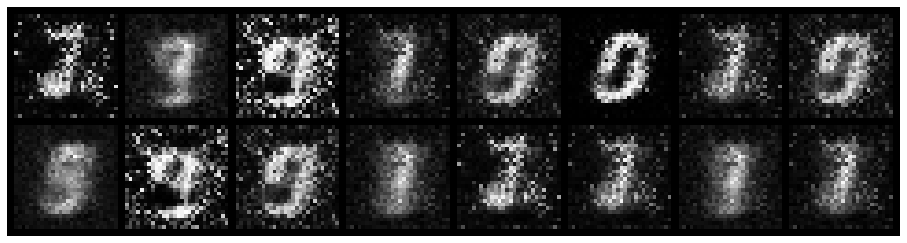

Epoch: [5/20], Batch Num: [400/600]
Discriminator Loss: 0.5898, Generator Loss: 2.4383
D(x): 0.8233, D(G(z)): 0.1649


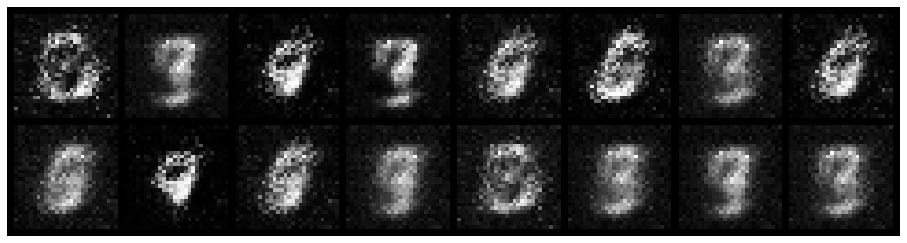

Epoch: [5/20], Batch Num: [500/600]
Discriminator Loss: 0.8655, Generator Loss: 1.7396
D(x): 0.6629, D(G(z)): 0.1595


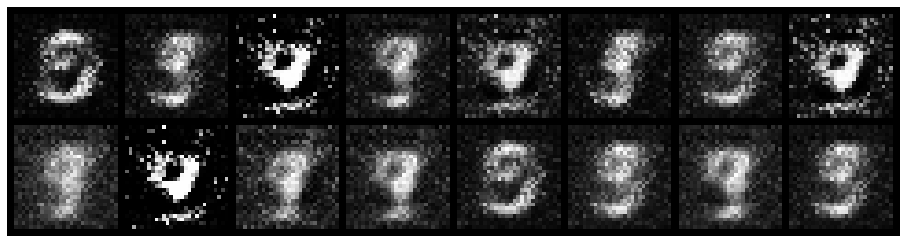

Epoch: [6/20], Batch Num: [0/600]
Discriminator Loss: 0.4575, Generator Loss: 2.9188
D(x): 0.8805, D(G(z)): 0.1424


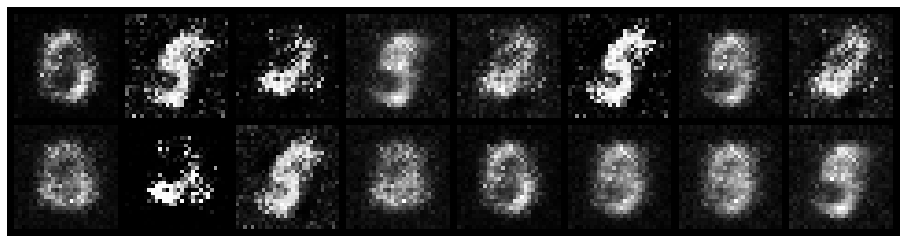

Epoch: [6/20], Batch Num: [100/600]
Discriminator Loss: 0.5886, Generator Loss: 2.7368
D(x): 0.8081, D(G(z)): 0.1710


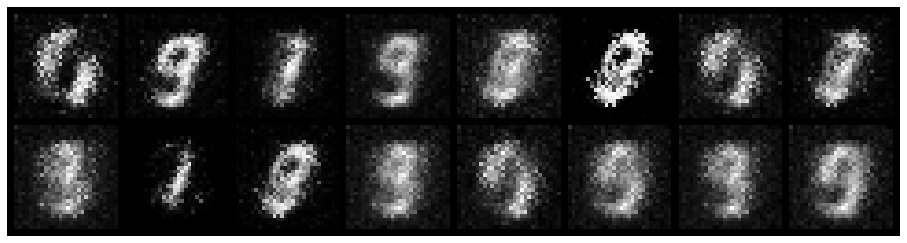

Epoch: [6/20], Batch Num: [200/600]
Discriminator Loss: 0.5805, Generator Loss: 2.8245
D(x): 0.8442, D(G(z)): 0.1958


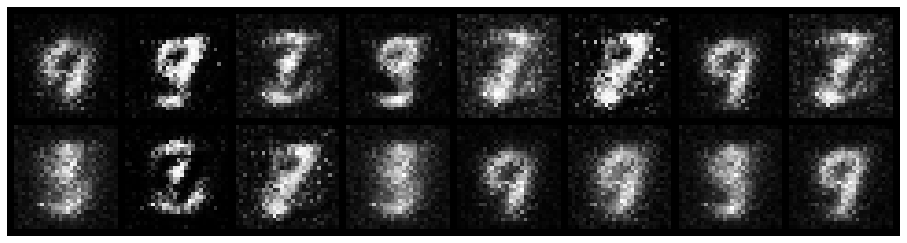

Epoch: [6/20], Batch Num: [300/600]
Discriminator Loss: 0.7116, Generator Loss: 2.1106
D(x): 0.8435, D(G(z)): 0.2779


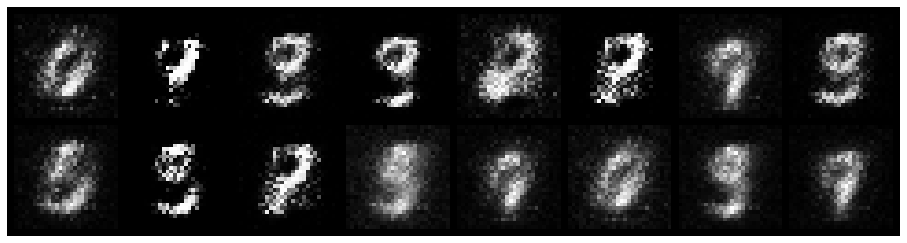

Epoch: [6/20], Batch Num: [400/600]
Discriminator Loss: 0.7309, Generator Loss: 2.1048
D(x): 0.8215, D(G(z)): 0.2444


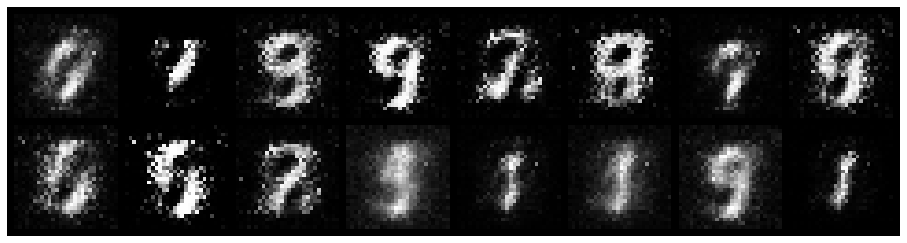

Epoch: [6/20], Batch Num: [500/600]
Discriminator Loss: 0.6284, Generator Loss: 1.8876
D(x): 0.7642, D(G(z)): 0.1753


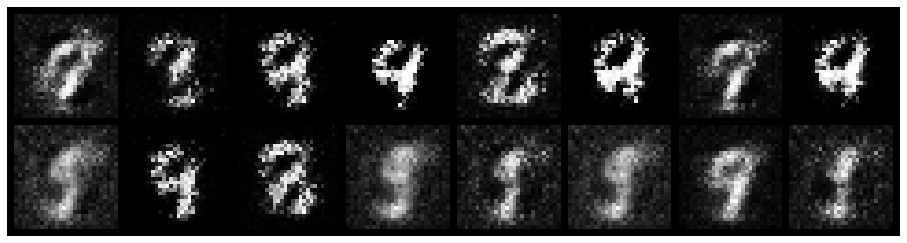

Epoch: [7/20], Batch Num: [0/600]
Discriminator Loss: 0.9272, Generator Loss: 1.5649
D(x): 0.6839, D(G(z)): 0.2674


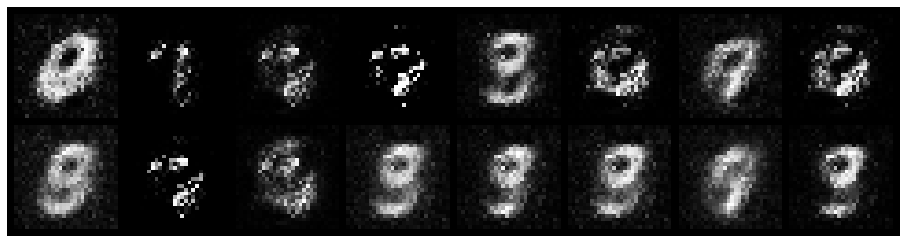

Epoch: [7/20], Batch Num: [100/600]
Discriminator Loss: 0.3786, Generator Loss: 2.4229
D(x): 0.8960, D(G(z)): 0.1745


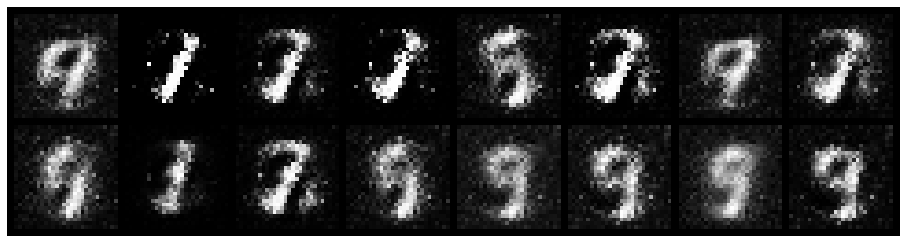

Epoch: [7/20], Batch Num: [200/600]
Discriminator Loss: 0.4886, Generator Loss: 2.7825
D(x): 0.8815, D(G(z)): 0.2031


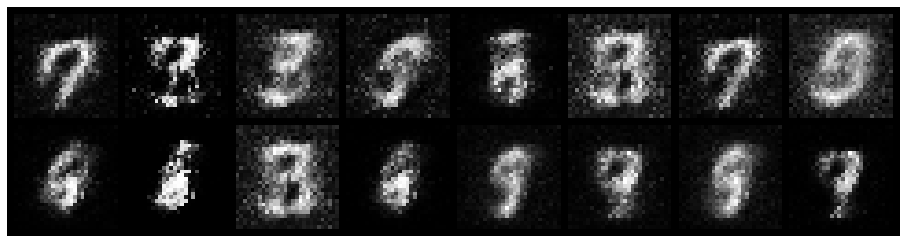

Epoch: [7/20], Batch Num: [300/600]
Discriminator Loss: 0.7763, Generator Loss: 1.6907
D(x): 0.7225, D(G(z)): 0.2141


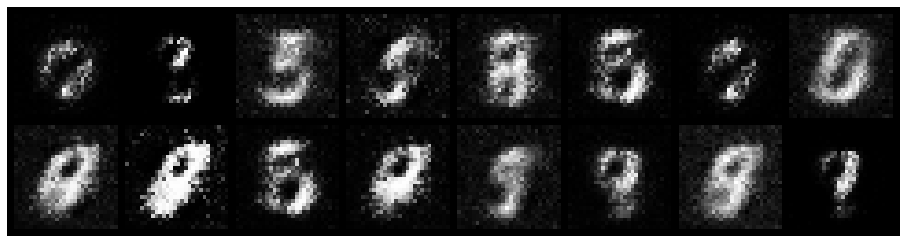

Epoch: [7/20], Batch Num: [400/600]
Discriminator Loss: 0.5285, Generator Loss: 2.3017
D(x): 0.7905, D(G(z)): 0.1557


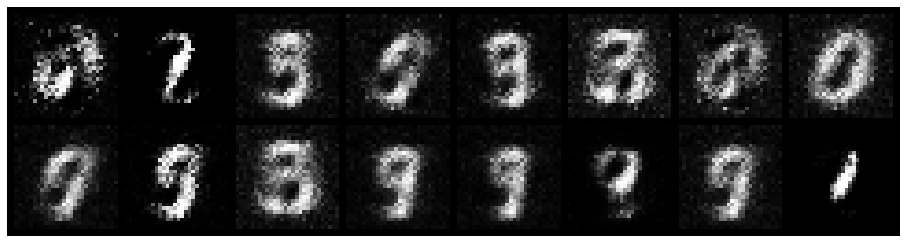

Epoch: [7/20], Batch Num: [500/600]
Discriminator Loss: 0.5407, Generator Loss: 2.1829
D(x): 0.8665, D(G(z)): 0.2046


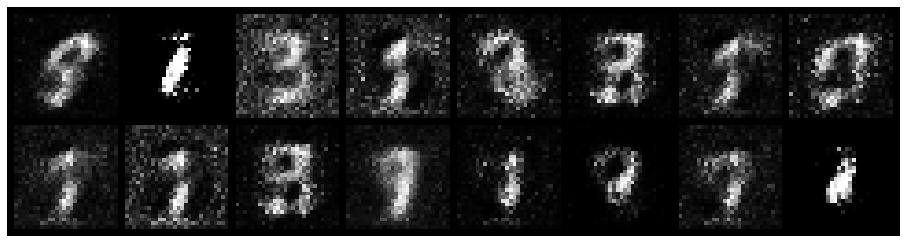

Epoch: [8/20], Batch Num: [0/600]
Discriminator Loss: 0.4464, Generator Loss: 2.9293
D(x): 0.8677, D(G(z)): 0.1703


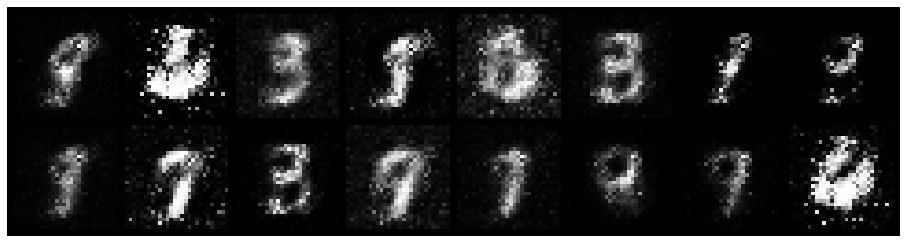

Epoch: [8/20], Batch Num: [100/600]
Discriminator Loss: 0.4930, Generator Loss: 2.5438
D(x): 0.8085, D(G(z)): 0.1283


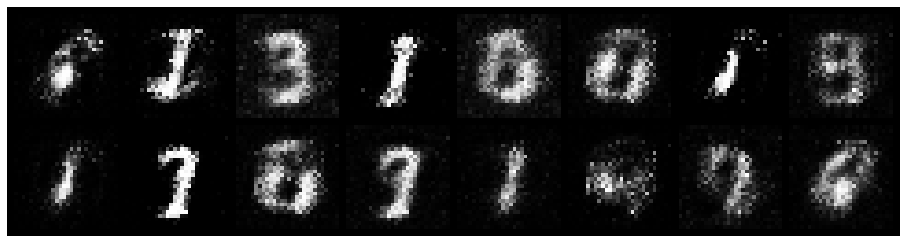

Epoch: [8/20], Batch Num: [200/600]
Discriminator Loss: 0.6386, Generator Loss: 2.2956
D(x): 0.7760, D(G(z)): 0.1382


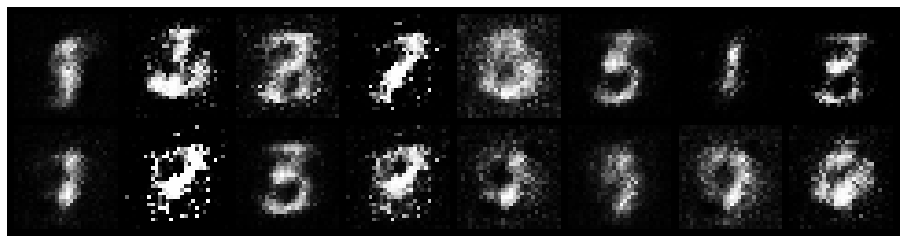

Epoch: [8/20], Batch Num: [300/600]
Discriminator Loss: 0.7270, Generator Loss: 2.7208
D(x): 0.7117, D(G(z)): 0.1125


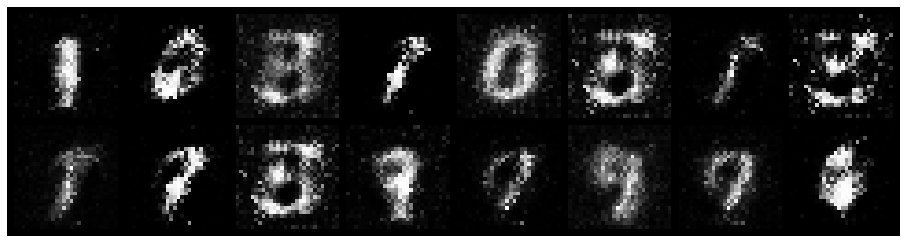

Epoch: [8/20], Batch Num: [400/600]
Discriminator Loss: 0.5308, Generator Loss: 2.5548
D(x): 0.8514, D(G(z)): 0.1667


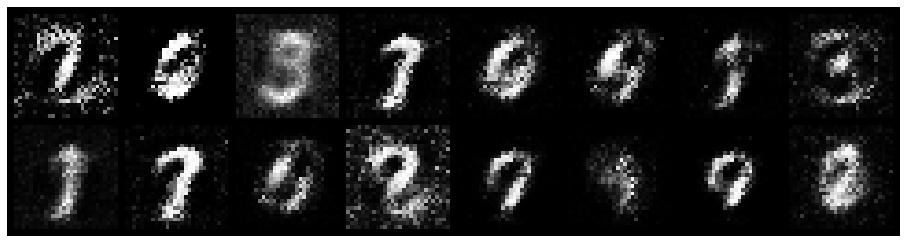

Epoch: [8/20], Batch Num: [500/600]
Discriminator Loss: 0.4815, Generator Loss: 2.5283
D(x): 0.8958, D(G(z)): 0.1837


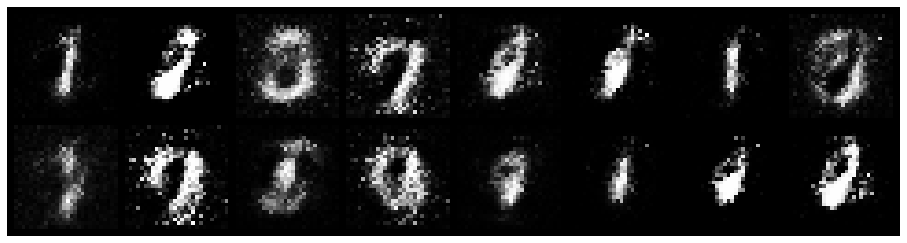

Epoch: [9/20], Batch Num: [0/600]
Discriminator Loss: 0.4148, Generator Loss: 2.6691
D(x): 0.8502, D(G(z)): 0.1224


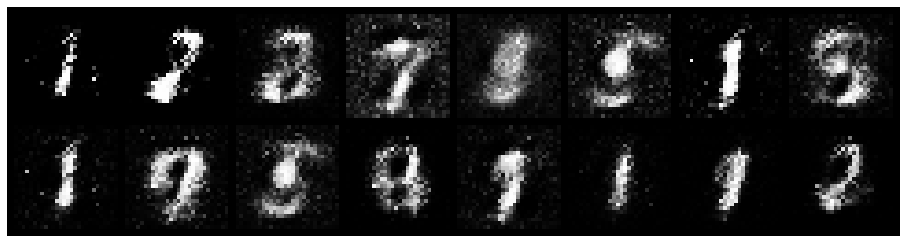

Epoch: [9/20], Batch Num: [100/600]
Discriminator Loss: 0.5657, Generator Loss: 3.2780
D(x): 0.8325, D(G(z)): 0.1475


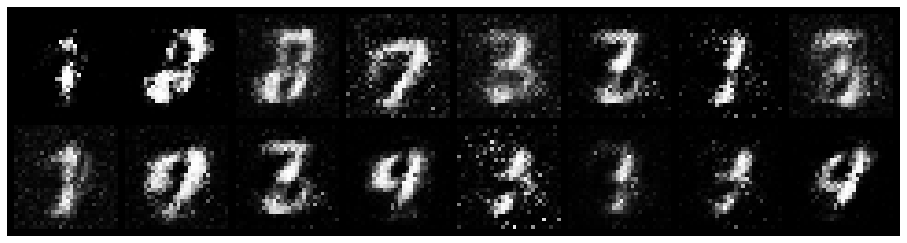

Epoch: [9/20], Batch Num: [200/600]
Discriminator Loss: 0.5957, Generator Loss: 2.9316
D(x): 0.8282, D(G(z)): 0.1843


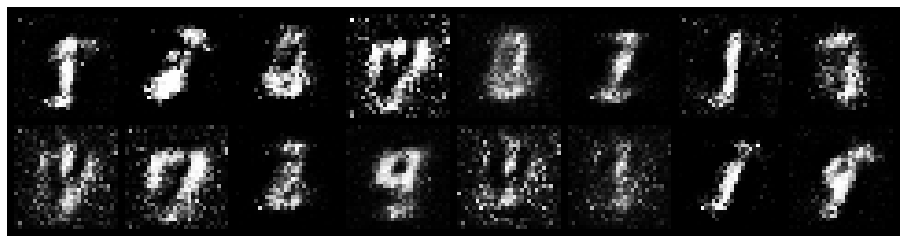

Epoch: [9/20], Batch Num: [300/600]
Discriminator Loss: 0.5171, Generator Loss: 2.4102
D(x): 0.8871, D(G(z)): 0.2452


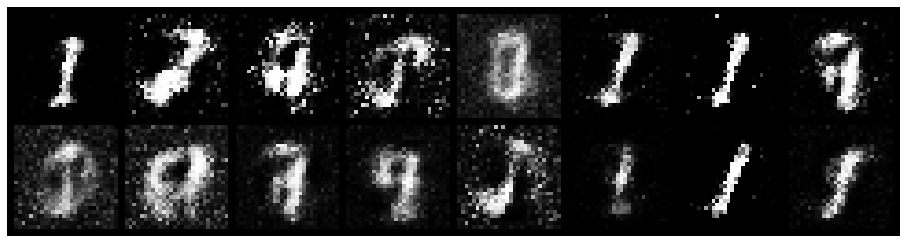

Epoch: [9/20], Batch Num: [400/600]
Discriminator Loss: 0.5910, Generator Loss: 2.0201
D(x): 0.7750, D(G(z)): 0.1715


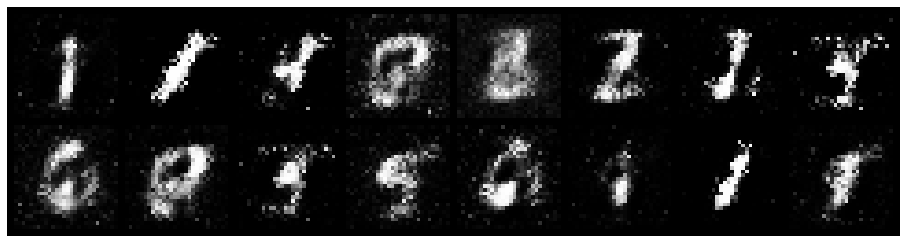

Epoch: [9/20], Batch Num: [500/600]
Discriminator Loss: 0.7564, Generator Loss: 1.8281
D(x): 0.7238, D(G(z)): 0.2103


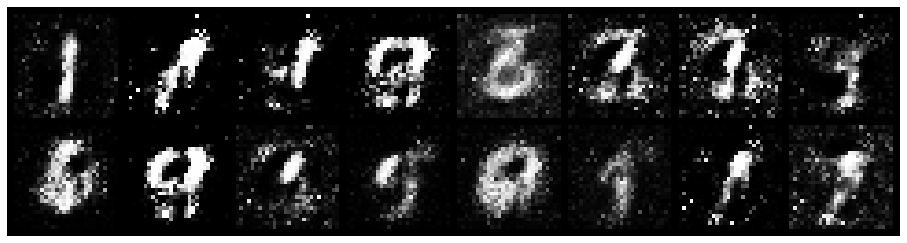

Epoch: [10/20], Batch Num: [0/600]
Discriminator Loss: 0.6085, Generator Loss: 2.5179
D(x): 0.8026, D(G(z)): 0.1929


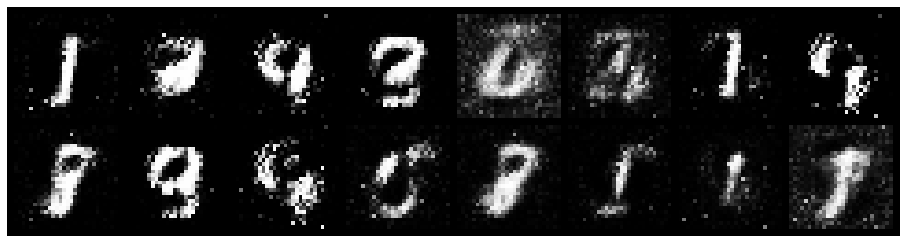

Epoch: [10/20], Batch Num: [100/600]
Discriminator Loss: 1.0730, Generator Loss: 1.9511
D(x): 0.7954, D(G(z)): 0.3754


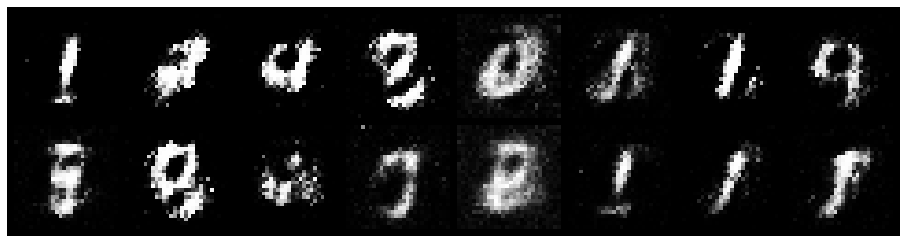

Epoch: [10/20], Batch Num: [200/600]
Discriminator Loss: 0.5639, Generator Loss: 2.4054
D(x): 0.8336, D(G(z)): 0.2002


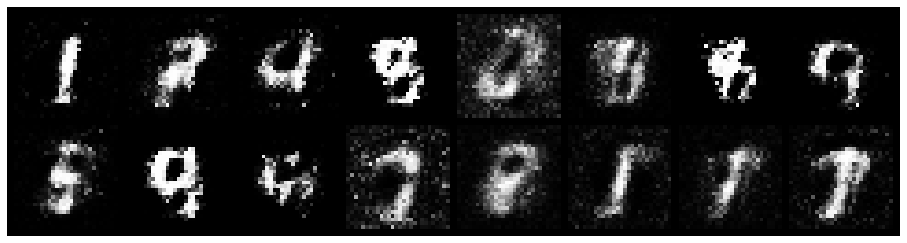

Epoch: [10/20], Batch Num: [300/600]
Discriminator Loss: 0.6315, Generator Loss: 2.2159
D(x): 0.7987, D(G(z)): 0.1999


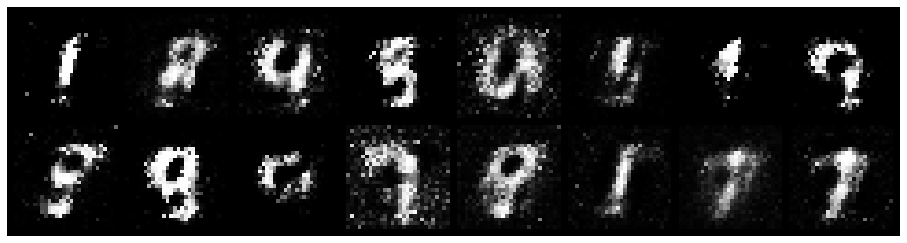

Epoch: [10/20], Batch Num: [400/600]
Discriminator Loss: 1.0339, Generator Loss: 1.4489
D(x): 0.6957, D(G(z)): 0.2713


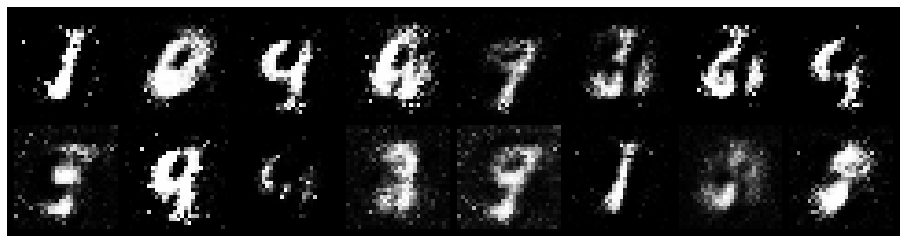

Epoch: [10/20], Batch Num: [500/600]
Discriminator Loss: 0.6857, Generator Loss: 1.9333
D(x): 0.8034, D(G(z)): 0.2550


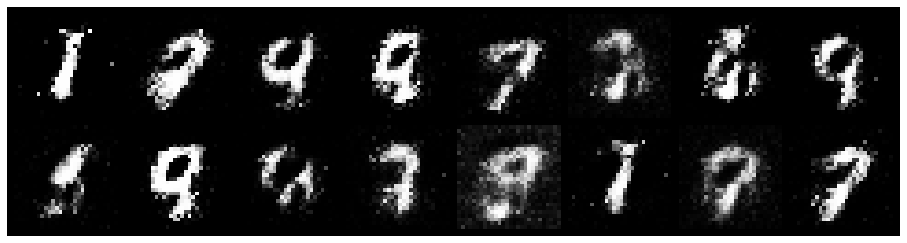

Epoch: [11/20], Batch Num: [0/600]
Discriminator Loss: 0.7543, Generator Loss: 2.5262
D(x): 0.8101, D(G(z)): 0.2696


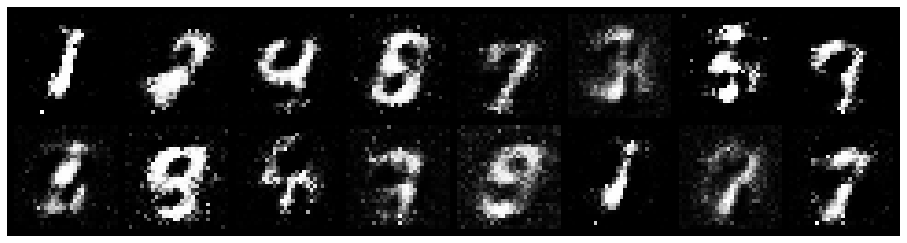

Epoch: [11/20], Batch Num: [100/600]
Discriminator Loss: 0.6753, Generator Loss: 2.5428
D(x): 0.7977, D(G(z)): 0.2328


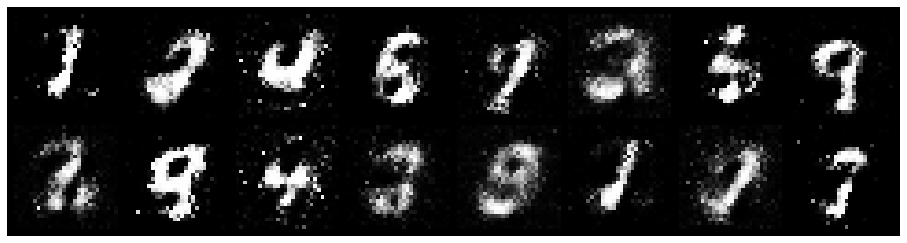

Epoch: [11/20], Batch Num: [200/600]
Discriminator Loss: 0.5260, Generator Loss: 2.6724
D(x): 0.8532, D(G(z)): 0.1987


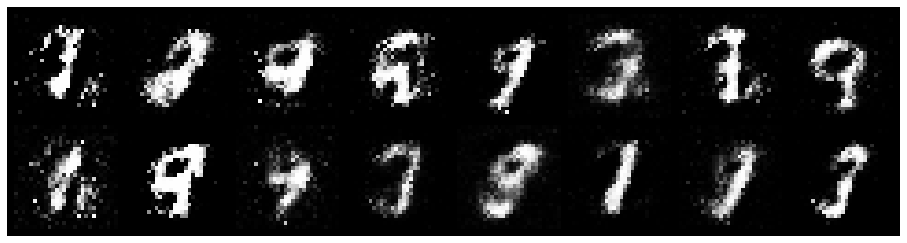

Epoch: [11/20], Batch Num: [300/600]
Discriminator Loss: 0.5446, Generator Loss: 1.8676
D(x): 0.8826, D(G(z)): 0.2555


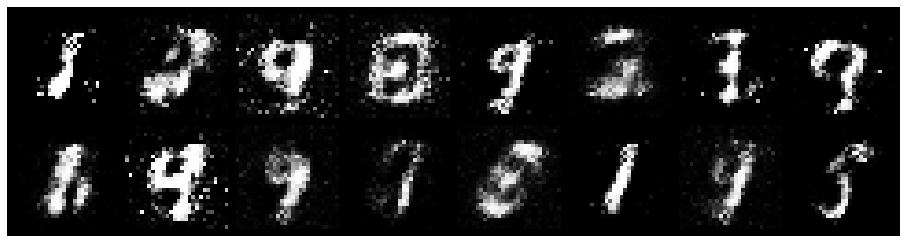

Epoch: [11/20], Batch Num: [400/600]
Discriminator Loss: 0.5432, Generator Loss: 2.4059
D(x): 0.8970, D(G(z)): 0.2563


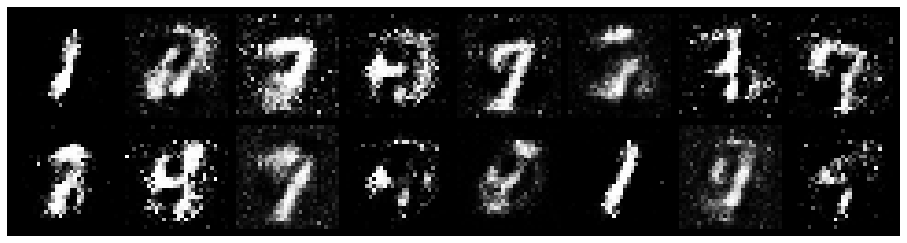

Epoch: [11/20], Batch Num: [500/600]
Discriminator Loss: 0.6418, Generator Loss: 1.9579
D(x): 0.7742, D(G(z)): 0.1824


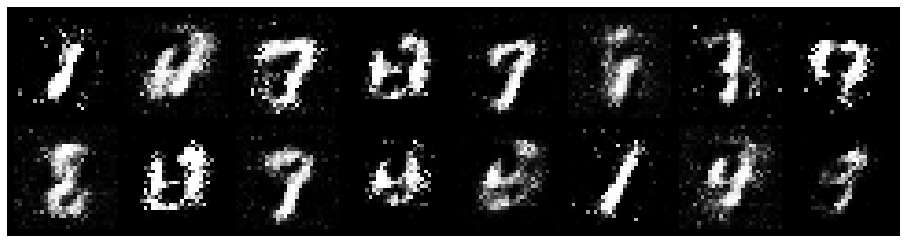

Epoch: [12/20], Batch Num: [0/600]
Discriminator Loss: 0.7397, Generator Loss: 2.0169
D(x): 0.8255, D(G(z)): 0.2946


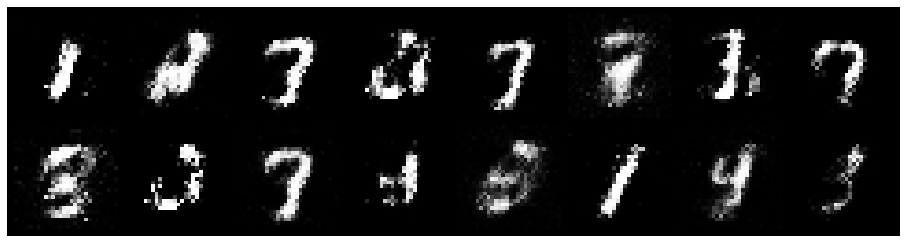

Epoch: [12/20], Batch Num: [100/600]
Discriminator Loss: 1.0153, Generator Loss: 1.5361
D(x): 0.8183, D(G(z)): 0.3985


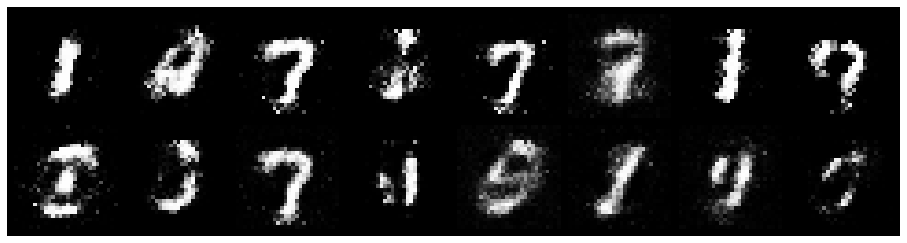

Epoch: [12/20], Batch Num: [200/600]
Discriminator Loss: 0.6147, Generator Loss: 2.0970
D(x): 0.7852, D(G(z)): 0.2149


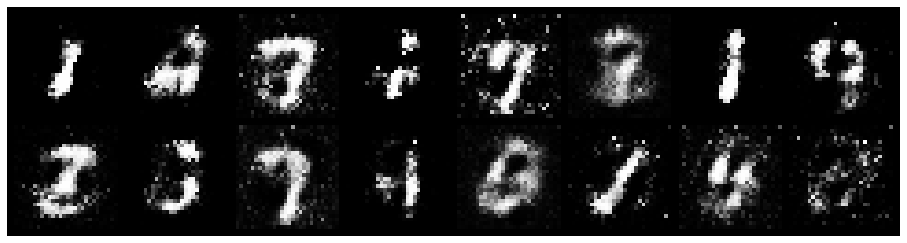

Epoch: [12/20], Batch Num: [300/600]
Discriminator Loss: 0.5583, Generator Loss: 2.3865
D(x): 0.7952, D(G(z)): 0.1806


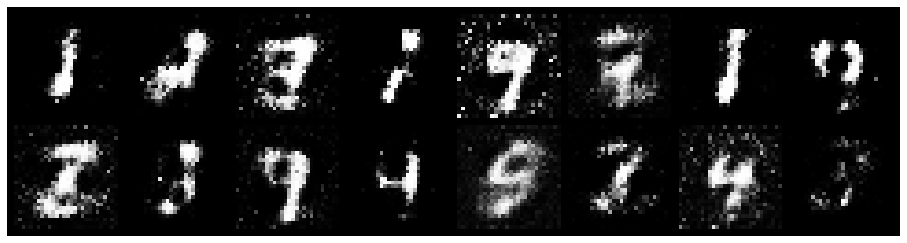

Epoch: [12/20], Batch Num: [400/600]
Discriminator Loss: 0.6794, Generator Loss: 2.0148
D(x): 0.8251, D(G(z)): 0.2572


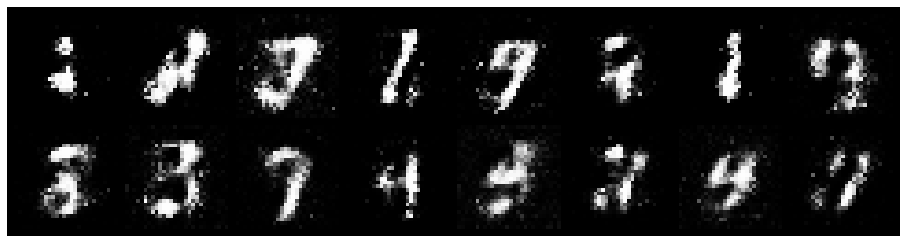

Epoch: [12/20], Batch Num: [500/600]
Discriminator Loss: 0.5997, Generator Loss: 1.9668
D(x): 0.8350, D(G(z)): 0.2048


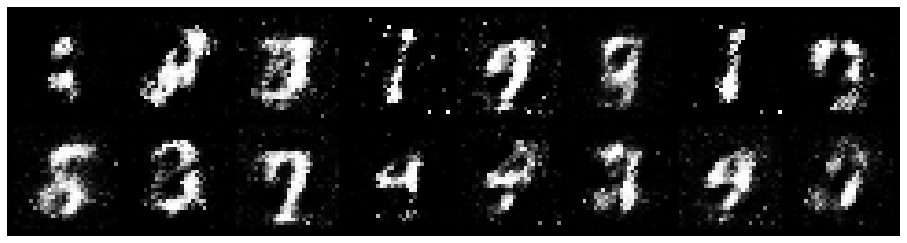

Epoch: [13/20], Batch Num: [0/600]
Discriminator Loss: 0.8069, Generator Loss: 2.0964
D(x): 0.7580, D(G(z)): 0.2219


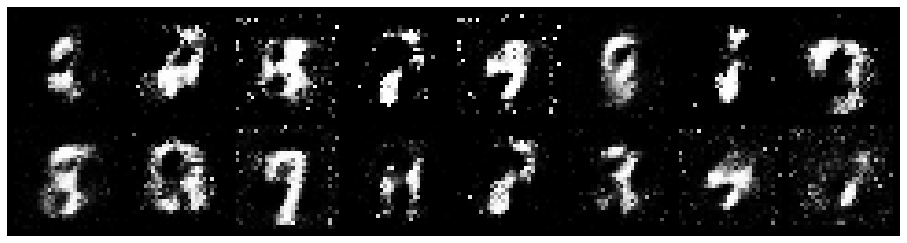

Epoch: [13/20], Batch Num: [100/600]
Discriminator Loss: 0.7601, Generator Loss: 1.9856
D(x): 0.7651, D(G(z)): 0.2195


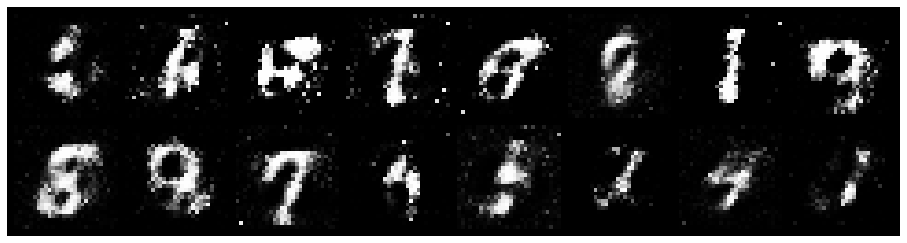

Epoch: [13/20], Batch Num: [200/600]
Discriminator Loss: 0.4921, Generator Loss: 2.1223
D(x): 0.8429, D(G(z)): 0.1987


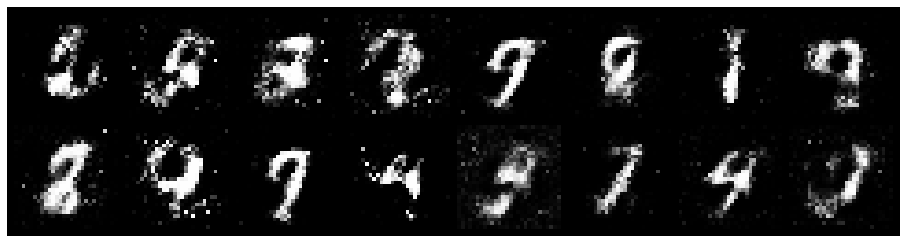

Epoch: [13/20], Batch Num: [300/600]
Discriminator Loss: 0.5662, Generator Loss: 2.2525
D(x): 0.8041, D(G(z)): 0.1990


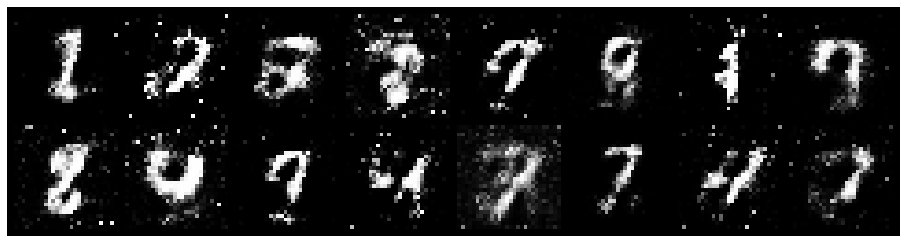

Epoch: [13/20], Batch Num: [400/600]
Discriminator Loss: 0.8629, Generator Loss: 1.5443
D(x): 0.6935, D(G(z)): 0.2841


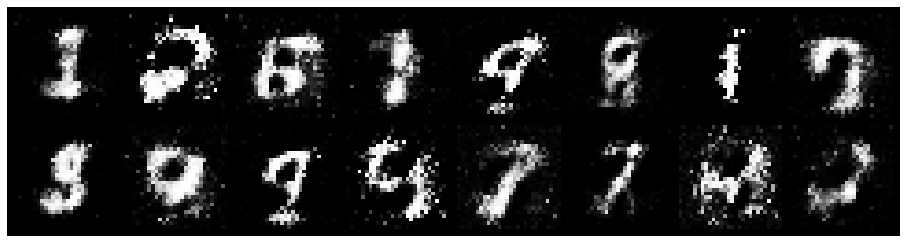

Epoch: [13/20], Batch Num: [500/600]
Discriminator Loss: 0.6109, Generator Loss: 1.8807
D(x): 0.7762, D(G(z)): 0.2132


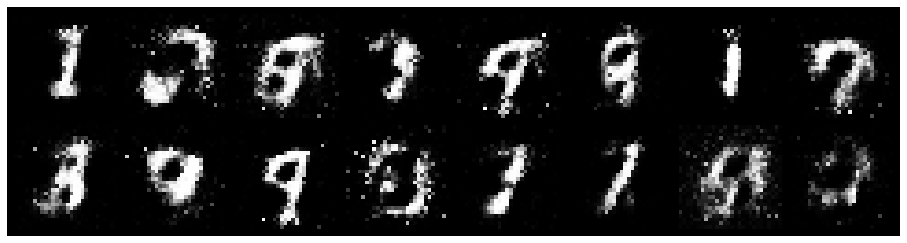

Epoch: [14/20], Batch Num: [0/600]
Discriminator Loss: 0.6474, Generator Loss: 2.3942
D(x): 0.7998, D(G(z)): 0.1918


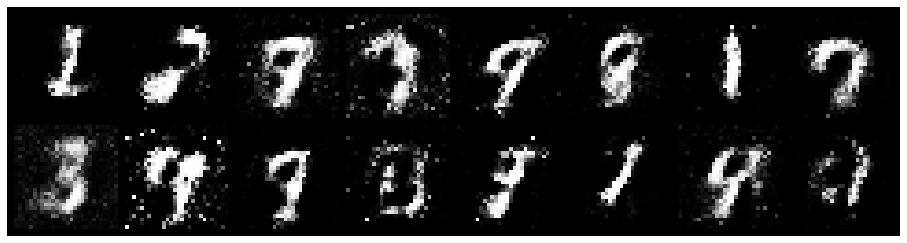

Epoch: [14/20], Batch Num: [100/600]
Discriminator Loss: 0.5371, Generator Loss: 2.0554
D(x): 0.8201, D(G(z)): 0.1735


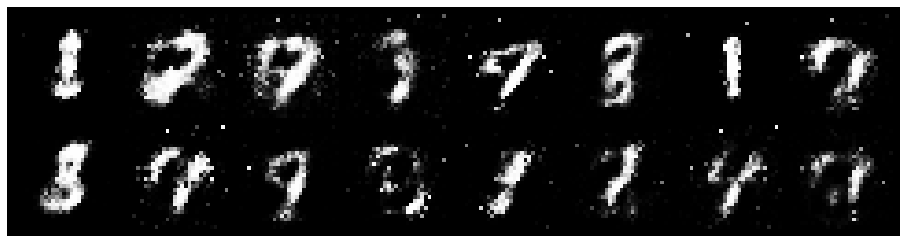

Epoch: [14/20], Batch Num: [200/600]
Discriminator Loss: 0.8681, Generator Loss: 1.9238
D(x): 0.7020, D(G(z)): 0.2588


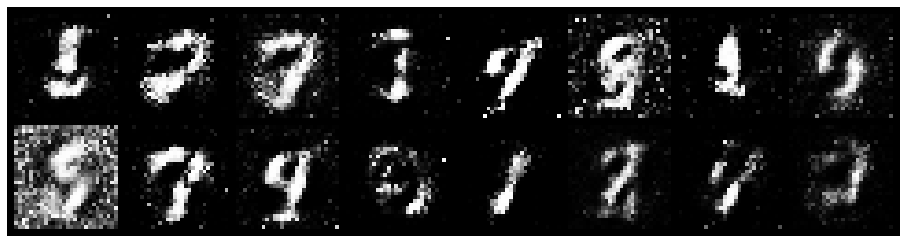

Epoch: [14/20], Batch Num: [300/600]
Discriminator Loss: 0.8444, Generator Loss: 2.1662
D(x): 0.7018, D(G(z)): 0.2530


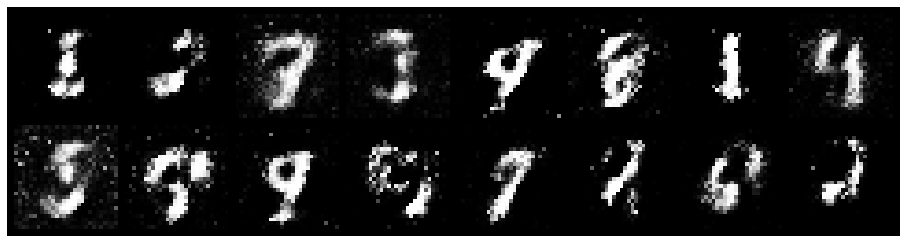

Epoch: [14/20], Batch Num: [400/600]
Discriminator Loss: 0.6888, Generator Loss: 1.6832
D(x): 0.7886, D(G(z)): 0.2609


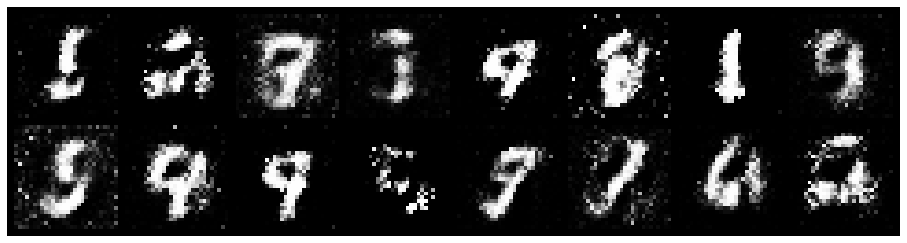

Epoch: [14/20], Batch Num: [500/600]
Discriminator Loss: 0.6792, Generator Loss: 2.1182
D(x): 0.7425, D(G(z)): 0.1896


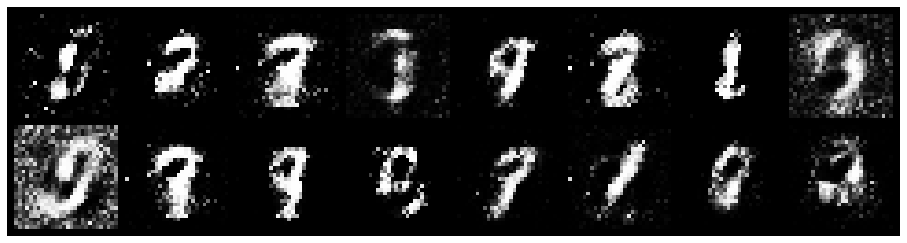

Epoch: [15/20], Batch Num: [0/600]
Discriminator Loss: 0.6112, Generator Loss: 2.0242
D(x): 0.7785, D(G(z)): 0.1924


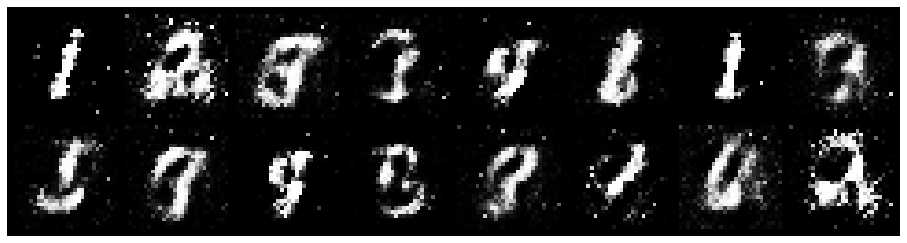

Epoch: [15/20], Batch Num: [100/600]
Discriminator Loss: 0.5654, Generator Loss: 2.1065
D(x): 0.7779, D(G(z)): 0.1721


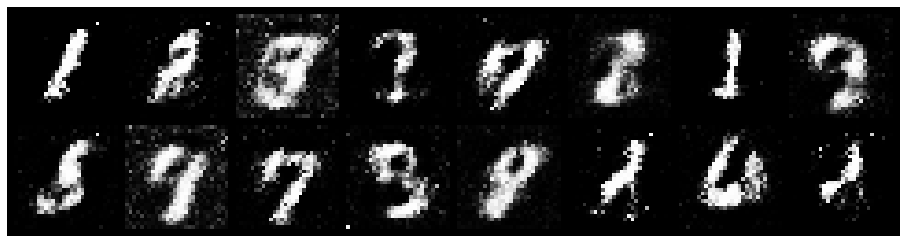

Epoch: [15/20], Batch Num: [200/600]
Discriminator Loss: 1.1200, Generator Loss: 1.5934
D(x): 0.6527, D(G(z)): 0.3031


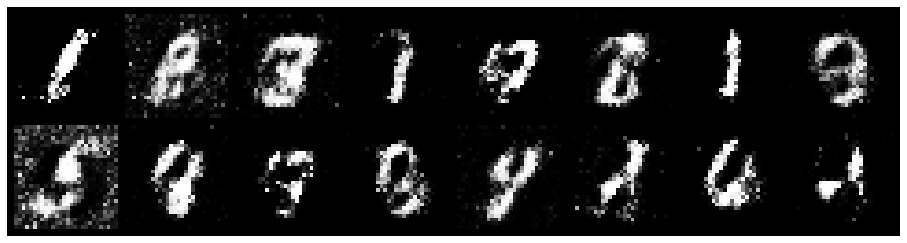

Epoch: [15/20], Batch Num: [300/600]
Discriminator Loss: 1.1686, Generator Loss: 1.8148
D(x): 0.7294, D(G(z)): 0.3768


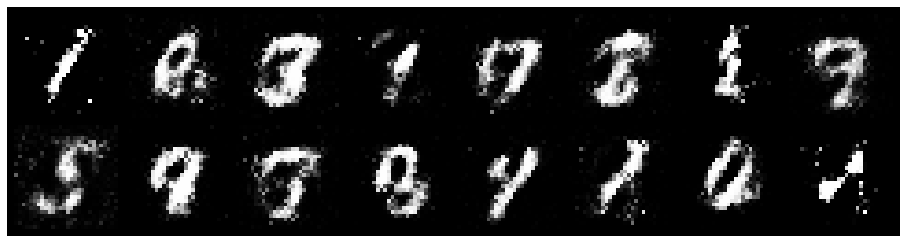

Epoch: [15/20], Batch Num: [400/600]
Discriminator Loss: 0.8531, Generator Loss: 2.2140
D(x): 0.7294, D(G(z)): 0.2666


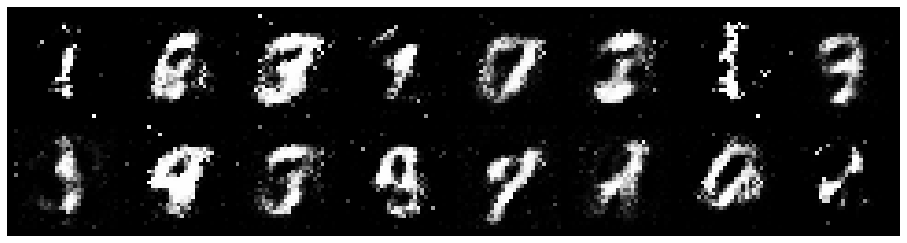

Epoch: [15/20], Batch Num: [500/600]
Discriminator Loss: 0.7068, Generator Loss: 2.0018
D(x): 0.8325, D(G(z)): 0.2984


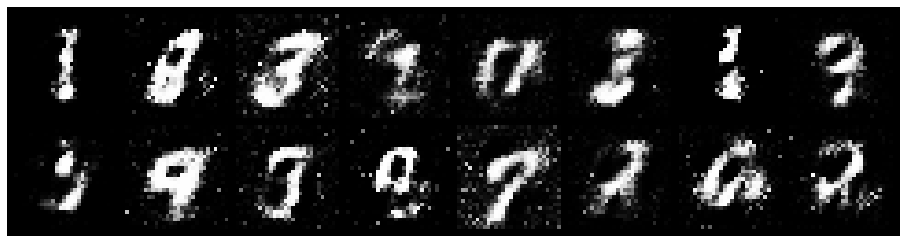

Epoch: [16/20], Batch Num: [0/600]
Discriminator Loss: 0.8199, Generator Loss: 2.2173
D(x): 0.6853, D(G(z)): 0.2281


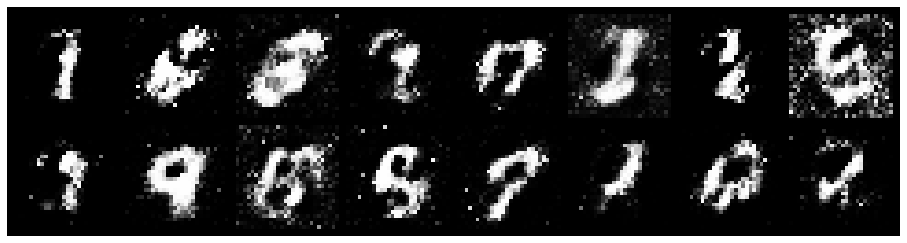

Epoch: [16/20], Batch Num: [100/600]
Discriminator Loss: 0.9293, Generator Loss: 2.5731
D(x): 0.6998, D(G(z)): 0.2719


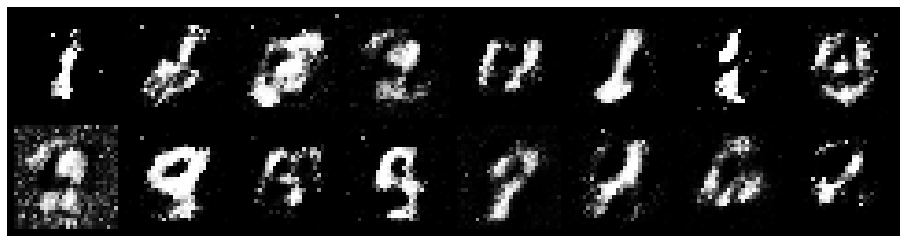

Epoch: [16/20], Batch Num: [200/600]
Discriminator Loss: 0.8016, Generator Loss: 1.7481
D(x): 0.7516, D(G(z)): 0.2891


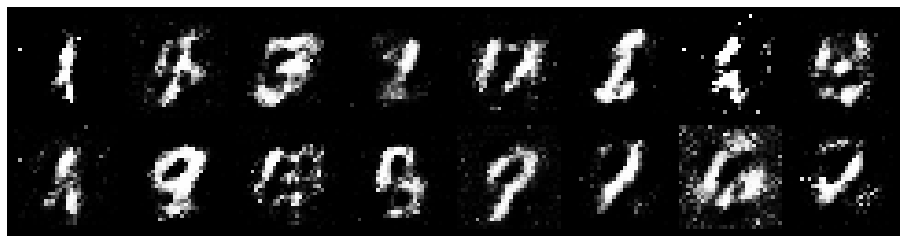

Epoch: [16/20], Batch Num: [300/600]
Discriminator Loss: 0.9990, Generator Loss: 1.3588
D(x): 0.6842, D(G(z)): 0.2694


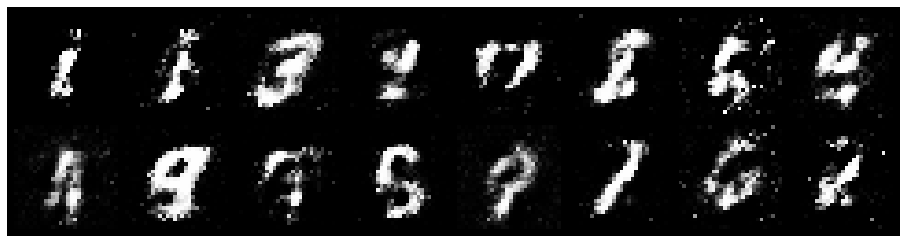

Epoch: [16/20], Batch Num: [400/600]
Discriminator Loss: 0.9305, Generator Loss: 1.6876
D(x): 0.6660, D(G(z)): 0.2149


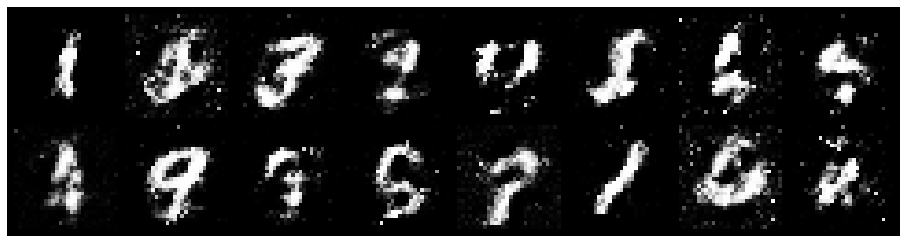

Epoch: [16/20], Batch Num: [500/600]
Discriminator Loss: 0.9604, Generator Loss: 1.7396
D(x): 0.6305, D(G(z)): 0.2026


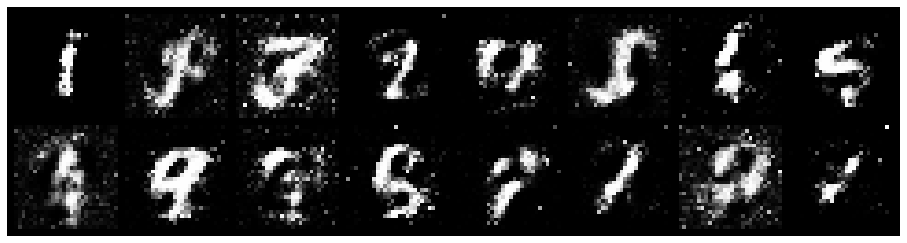

Epoch: [17/20], Batch Num: [0/600]
Discriminator Loss: 1.0366, Generator Loss: 1.3822
D(x): 0.7298, D(G(z)): 0.3367


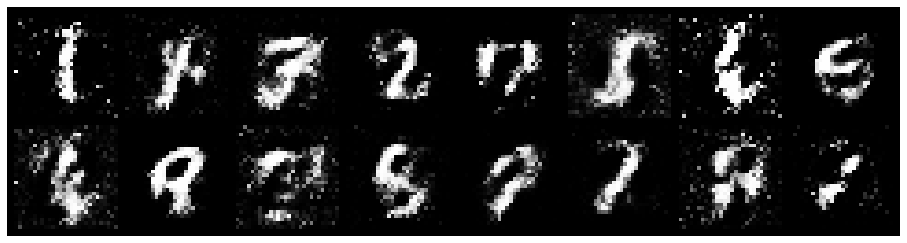

Epoch: [17/20], Batch Num: [100/600]
Discriminator Loss: 1.1021, Generator Loss: 1.1374
D(x): 0.7208, D(G(z)): 0.3947


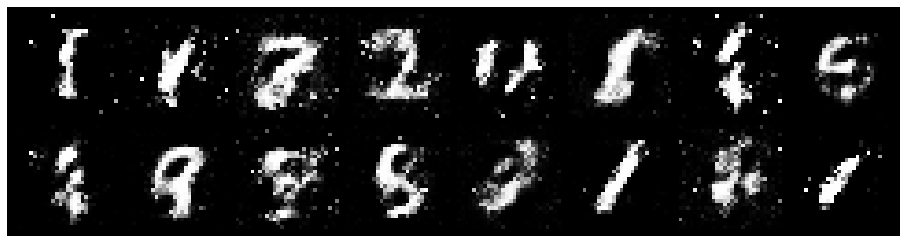

Epoch: [17/20], Batch Num: [200/600]
Discriminator Loss: 1.0483, Generator Loss: 1.4412
D(x): 0.6588, D(G(z)): 0.3280


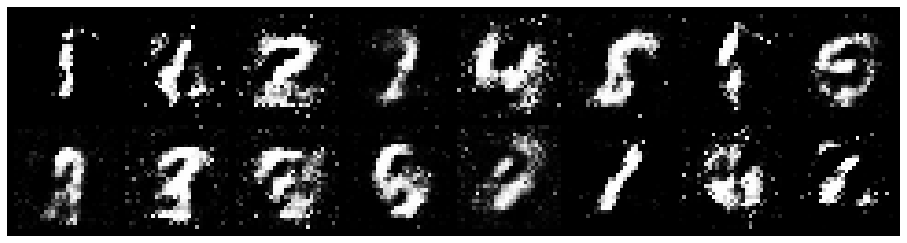

Epoch: [17/20], Batch Num: [300/600]
Discriminator Loss: 0.8998, Generator Loss: 1.4455
D(x): 0.6734, D(G(z)): 0.2533


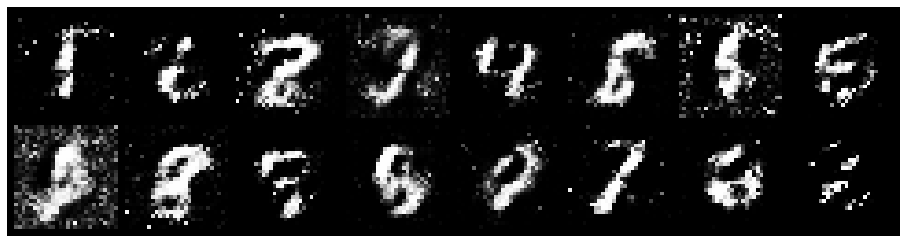

Epoch: [17/20], Batch Num: [400/600]
Discriminator Loss: 0.7577, Generator Loss: 1.9375
D(x): 0.7383, D(G(z)): 0.2576


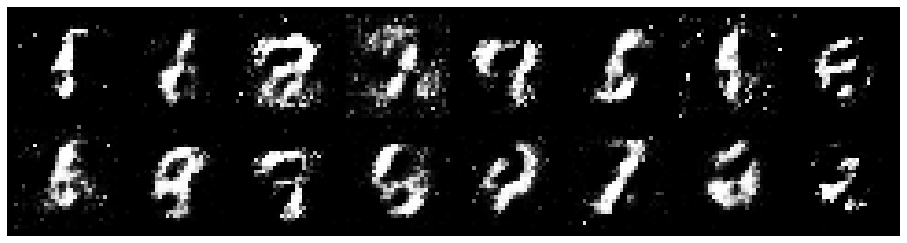

Epoch: [17/20], Batch Num: [500/600]
Discriminator Loss: 0.7459, Generator Loss: 1.6364
D(x): 0.8209, D(G(z)): 0.3188


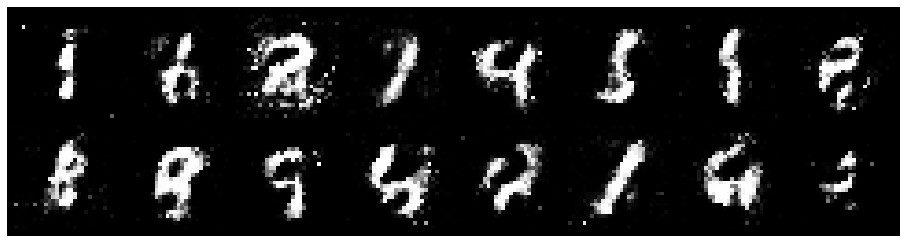

Epoch: [18/20], Batch Num: [0/600]
Discriminator Loss: 0.5275, Generator Loss: 2.0282
D(x): 0.8020, D(G(z)): 0.1930


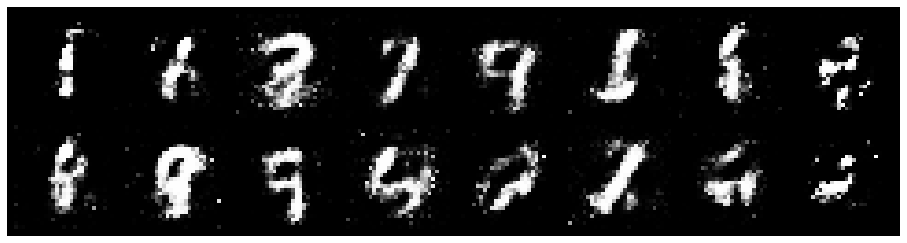

Epoch: [18/20], Batch Num: [100/600]
Discriminator Loss: 0.9321, Generator Loss: 1.9195
D(x): 0.7097, D(G(z)): 0.2831


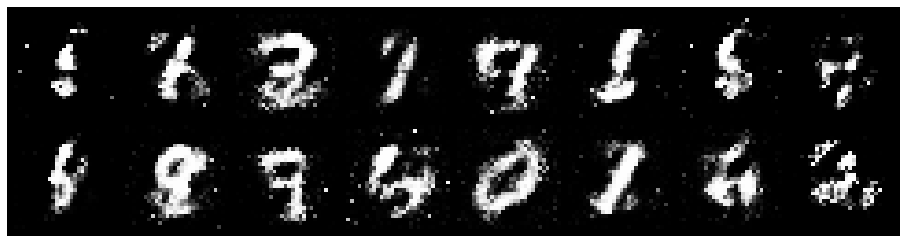

Epoch: [18/20], Batch Num: [200/600]
Discriminator Loss: 1.0166, Generator Loss: 1.5198
D(x): 0.6396, D(G(z)): 0.2952


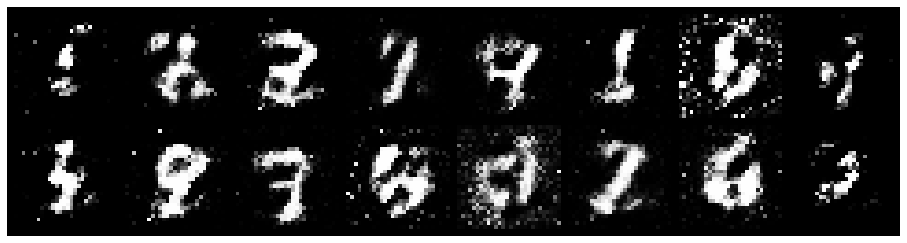

Epoch: [18/20], Batch Num: [300/600]
Discriminator Loss: 0.9871, Generator Loss: 1.1823
D(x): 0.6913, D(G(z)): 0.3553


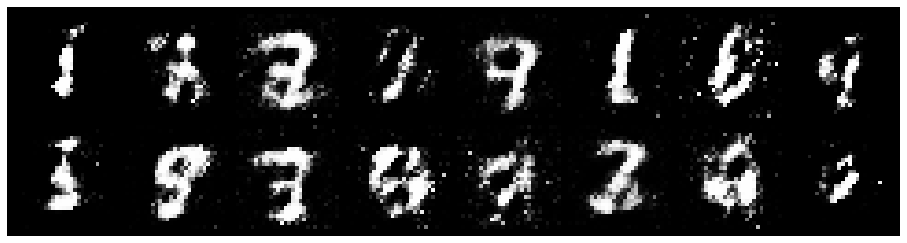

Epoch: [18/20], Batch Num: [400/600]
Discriminator Loss: 0.7552, Generator Loss: 1.7157
D(x): 0.6973, D(G(z)): 0.2307


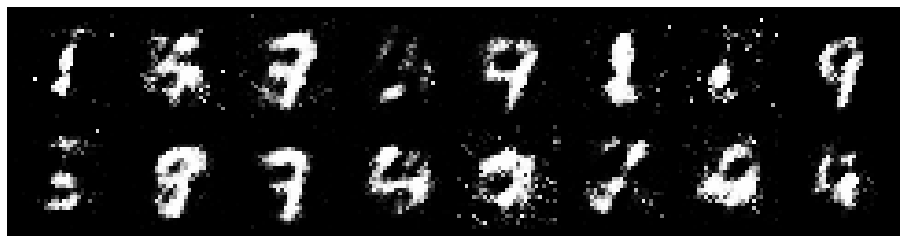

Epoch: [18/20], Batch Num: [500/600]
Discriminator Loss: 0.9396, Generator Loss: 1.4695
D(x): 0.6873, D(G(z)): 0.3266


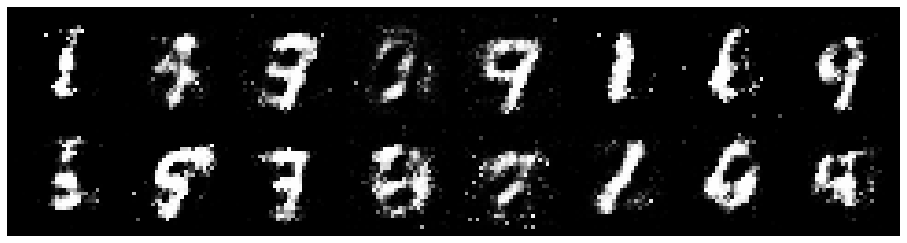

Epoch: [19/20], Batch Num: [0/600]
Discriminator Loss: 0.9375, Generator Loss: 1.2947
D(x): 0.7114, D(G(z)): 0.3462


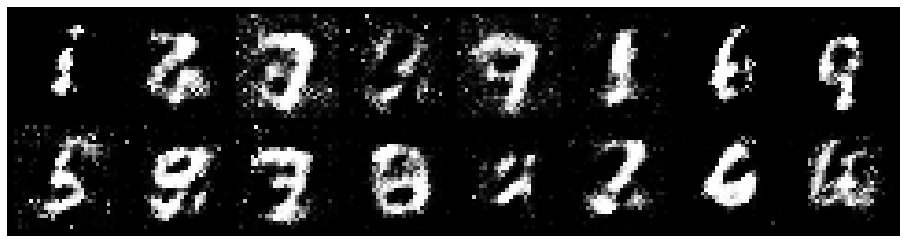

Epoch: [19/20], Batch Num: [100/600]
Discriminator Loss: 1.2983, Generator Loss: 1.0105
D(x): 0.6719, D(G(z)): 0.4388


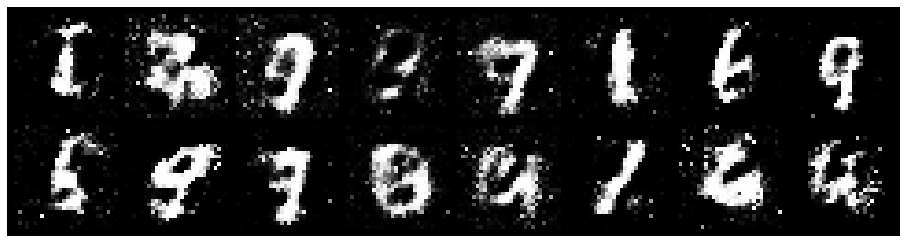

Epoch: [19/20], Batch Num: [200/600]
Discriminator Loss: 0.8472, Generator Loss: 2.0319
D(x): 0.7274, D(G(z)): 0.2405


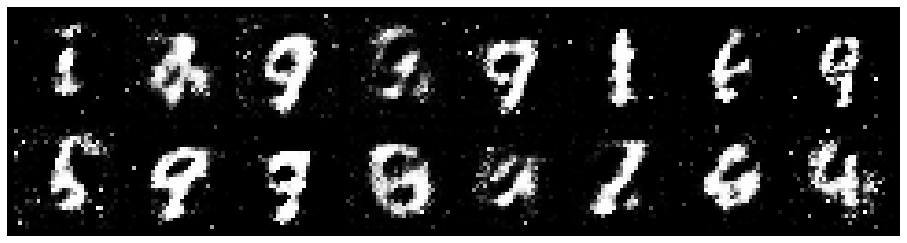

Epoch: [19/20], Batch Num: [300/600]
Discriminator Loss: 1.0351, Generator Loss: 1.5776
D(x): 0.6968, D(G(z)): 0.3575


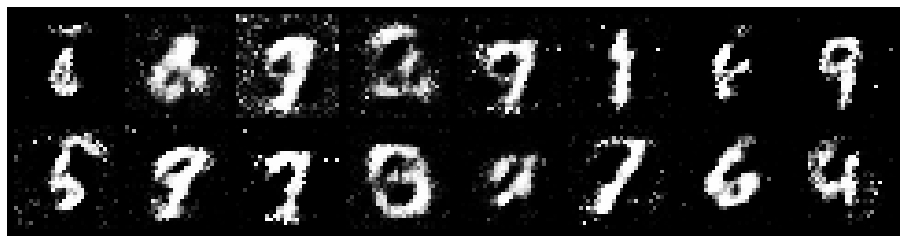

Epoch: [19/20], Batch Num: [400/600]
Discriminator Loss: 1.0753, Generator Loss: 1.1764
D(x): 0.7509, D(G(z)): 0.4126


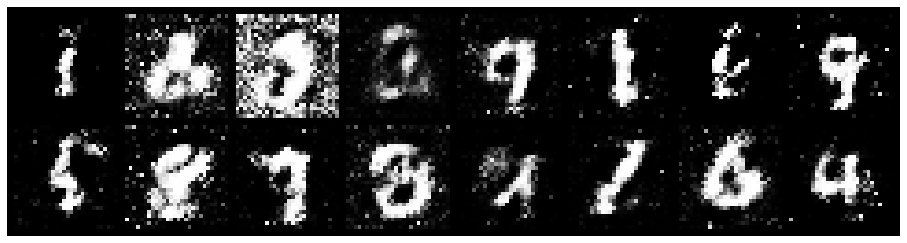

Epoch: [19/20], Batch Num: [500/600]
Discriminator Loss: 1.1217, Generator Loss: 1.6203
D(x): 0.5739, D(G(z)): 0.2691


In [42]:
# Create logger instance
logger = Logger(model_name='VGAN', data_name='MNIST')
# Total number of epochs to train
num_epochs = 20
for epoch in range(num_epochs):
    for n_batch, (real_batch,_) in enumerate(data_loader):
        N = real_batch.size(0)
        
        # 1. Train Discriminator
        real_data = Variable(images_to_vectors(real_batch))
        
        # Generate fake data and detach 
        # (so gradients are not calculated for generator)
        fake_data = generator(noise(N)).detach()
        
        # Train D
        d_error, d_pred_real, d_pred_fake = \
              train_discriminator(d_optimizer, real_data, fake_data)

        # 2. Train Generator
        # Generate fake data
        fake_data = generator(noise(N))
        
        # Train G
        g_error = train_generator(g_optimizer, fake_data)
        
        # Log batch error
        logger.log(d_error, g_error, epoch, n_batch, num_batches)
        
        # Display Progress every few batches
        if (n_batch) % 100 == 0: 
            test_images = vectors_to_images(generator(test_noise))
            test_images = test_images.data
            logger.log_images(
                test_images, num_test_samples, 
                epoch, n_batch, num_batches
            );
            # Display status Logs
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )